In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col,count, when,countDistinct
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from sklearn.feature_selection import VarianceThreshold
from pyspark.ml import Pipeline

In [3]:
import seaborn as sns
import numpy as np

In [4]:
spark = SparkSession.builder.appName("SDOH").getOrCreate()

df = spark.read.csv('sdoh_2020_tract_1_0.csv', header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/07 12:11:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df.columns

['YEAR',
 'TRACTFIPS',
 'COUNTYFIPS',
 'STATEFIPS',
 'STATE',
 'COUNTY',
 'REGION',
 'TERRITORY',
 'ACS_TOT_POP_WT',
 'ACS_TOT_POP_US_ABOVE1',
 'ACS_TOT_POP_ABOVE5',
 'ACS_TOT_POP_ABOVE15',
 'ACS_TOT_POP_ABOVE16',
 'ACS_TOT_POP_16_19',
 'ACS_TOT_POP_ABOVE25',
 'ACS_TOT_CIVIL_POP_ABOVE18',
 'ACS_TOT_CIVIL_VET_POP_ABOVE25',
 'ACS_TOT_OWN_CHILD_BELOW17',
 'ACS_TOT_CIVILIAN_LABOR',
 'ACS_TOT_CIVIL_EMPLOY_POP',
 'ACS_TOT_WORKER_HH',
 'ACS_TOT_WORKER_NWFH',
 'ACS_TOT_CIVIL_NONINST_POP_POV',
 'ACS_TOT_CIVIL_POP_POV',
 'ACS_TOT_POP_POV',
 'ACS_TOT_GRANDCHILDREN_GP',
 'ACS_TOT_HU',
 'ACS_TOT_HH',
 'ACS_AVG_HH_SIZE',
 'ACS_TOT_CIVIL_NONINST_POP',
 'ACS_TOT_CIVIL_VET_POP',
 'ACS_PCT_CHILD_DISAB',
 'ACS_PCT_DISABLE',
 'ACS_PCT_NONVET_DISABLE_18_64',
 'ACS_PCT_VET_DISABLE_18_64',
 'ACS_PCT_FEMALE',
 'ACS_PCT_MALE',
 'ACS_PCT_CTZ_ABOVE18',
 'ACS_PCT_CTZ_NATURALIZED',
 'ACS_PCT_CTZ_NONUS_BORN',
 'ACS_PCT_CTZ_US_BORN',
 'ACS_PCT_FOREIGN_BORN',
 'ACS_PCT_NON_CITIZEN',
 'ACS_PCT_NONCTN_1990',
 'ACS_PCT_

In [6]:
missing_data = df.select([((df[c].isNull()).cast("int").alias(c)) for c in df.columns])
missing_percentage = missing_data.agg(
    *[
        (F.sum(missing_data[c]) / df.count() * 100).alias(c) 
        for c in missing_data.columns
    ]
)
missing_percentage_dict = missing_percentage.collect()[0].asDict()
missing_percentage_pd = pd.DataFrame(
    list(missing_percentage_dict.items()), columns=["Column", "Missing_Percentage"]
)

missing_percentage_pd.to_csv('missing_percentages_sdoh_tract.csv', index=False)

25/01/07 12:12:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


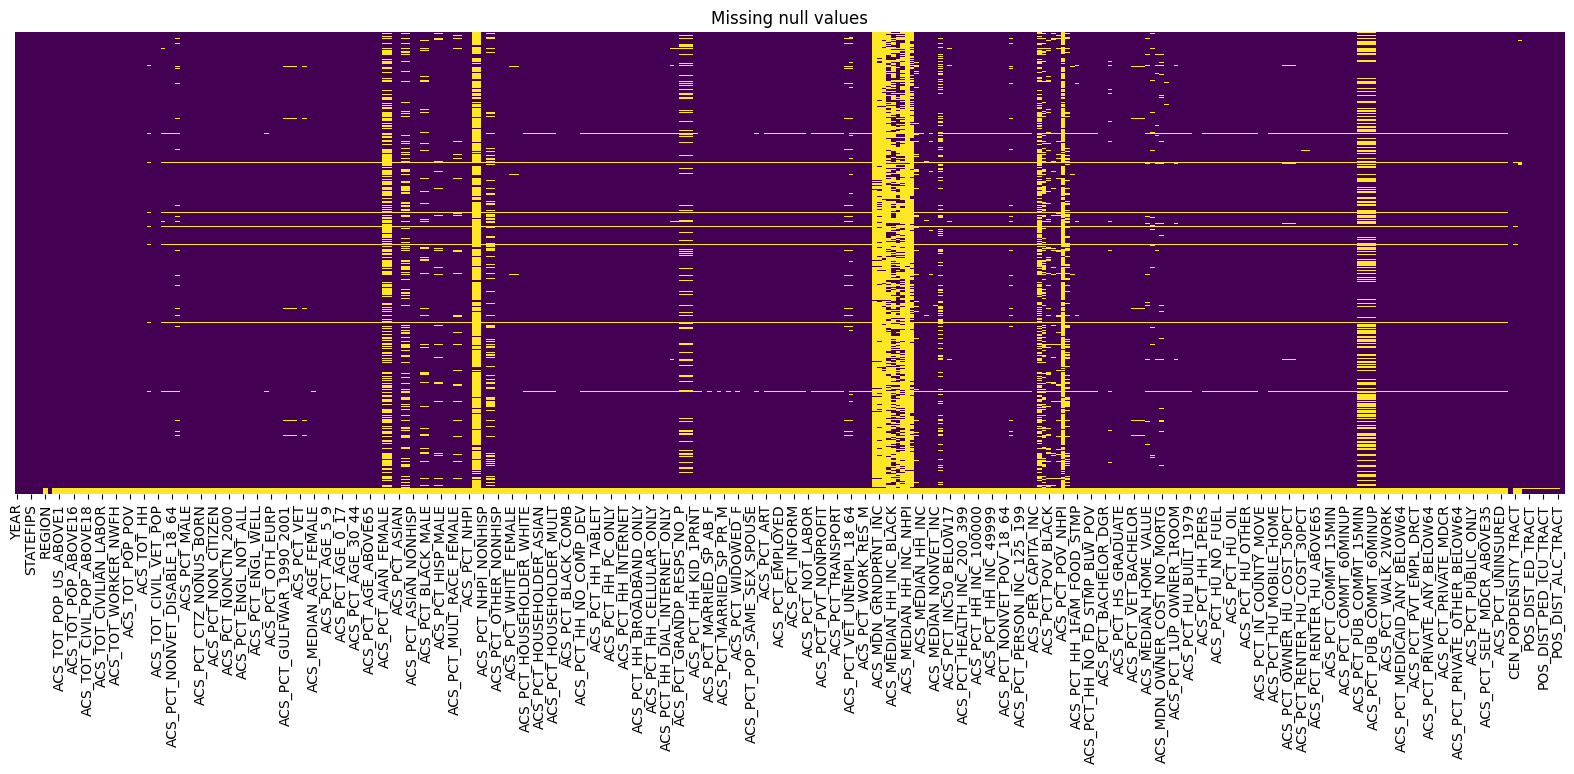

In [7]:
missing_matrix = missing_data.toPandas()
plt.rcParams['figure.figsize'] = (20,6)
sns.heatmap(missing_matrix, yticklabels = False, cbar = False , cmap = 'viridis')
plt.title("Missing null values")
plt.show()

In [8]:
print('Number of States: ', df.select('STATEFIPS').distinct().count())
print('Number of Region: ', df.select('REGION').distinct().count())

Number of States:  56
Number of Region:  5


In [9]:
sdoh = pd.read_csv('sdohVariables.csv')
sdoh = sdoh[['Topic', 'Variable Name']].drop_duplicates().fillna('Spatial')
sdoh

Topic                 Variable Name
0     Demographics               ACS_AVG_HH_SIZE
1           Income                ACS_GINI_INDEX
2           Income          ACS_MDN_GRNDPRNT_INC
3           Income  ACS_MDN_GRNDPRNT_NO_PRNT_INC
4          Housing   ACS_MDN_OWNER_COST_MORTGAGE
...            ...                           ...
1400       Spatial                     TRACTFIPS
1401   Environment                WUSTL_AVG_PM25
1402       Spatial                          YEAR
1403       Spatial                          ZCTA
1404       Spatial                       ZIPCODE

[1405 rows x 2 columns]

In [10]:
sdoh['sdoh_col'] = sdoh['Variable Name'].isin(df.columns).astype(int)
sdoh

Topic                 Variable Name  sdoh_col
0     Demographics               ACS_AVG_HH_SIZE         1
1           Income                ACS_GINI_INDEX         1
2           Income          ACS_MDN_GRNDPRNT_INC         1
3           Income  ACS_MDN_GRNDPRNT_NO_PRNT_INC         1
4          Housing   ACS_MDN_OWNER_COST_MORTGAGE         1
...            ...                           ...       ...
1400       Spatial                     TRACTFIPS         1
1401   Environment                WUSTL_AVG_PM25         1
1402       Spatial                          YEAR         1
1403       Spatial                          ZCTA         0
1404       Spatial                       ZIPCODE         0

[1405 rows x 3 columns]

In [11]:
not_in = sdoh[sdoh['sdoh_col'] == 0]
not_in

Topic  \
255                                Demographics   
310   Characteristics of health care facilities   
311   Characteristics of health care facilities   
312   Characteristics of health care facilities   
313   Characteristics of health care facilities   
...                                         ...   
1394                                   Numeracy   
1395                                   Numeracy   
1396                                   Numeracy   
1403                                    Spatial   
1404                                    Spatial   

                         Variable Name  sdoh_col  
255       ACS_PCT_SAME_SEX_UNMRD_PRTNR         0  
310   AHA_HHI_SHRTTRM_ACUTE_ADMSN_CBSA         0  
311    AHA_HHI_SHRTTRM_ACUTE_ADMSN_CTY         0  
312   AHA_HHI_SHRTTRM_ACUTE_DSCHR_CBSA         0  
313    AHA_HHI_SHRTTRM_ACUTE_DSCHR_CTY         0  
...                                ...       ...  
1394                 SEDA_MATH_GR8_WHG         0  
1395                 SEDA_MATH_GR8_WMG         0  
1396                 SEDA_MATH_GR8_WNG         0  
1403                              ZCTA         0  
1404                           ZIPCODE         0  

[1076 rows x 3 columns]

In [12]:
sdoh = sdoh.drop(sdoh[sdoh['sdoh_col'] == 0].index)
sdoh.to_csv('sdohTopics.csv')

In [13]:
print('Topics: ', sdoh['Topic'].unique())

Topics:  ['Demographics' 'Income' 'Housing' 'Employment' 'Attainment'
 'Living conditions' 'Disability' 'Transportation' 'Immigration'
 'Migration' 'Poverty' 'Internet connectivity' 'Health insurance status'
 'Geography' 'Spatial' 'Distance to Provider'
 'Characteristics of health care facilities' 'Environment']


In [14]:
grouped = sdoh.groupby('Topic')['Variable Name'].apply(list).reset_index()
grouped.to_csv('sdohTopics.csv')
grouped

Topic  \
0                                  Attainment   
1   Characteristics of health care facilities   
2                                Demographics   
3                                  Disability   
4                        Distance to Provider   
5                                  Employment   
6                                 Environment   
7                                   Geography   
8                     Health insurance status   
9                                     Housing   
10                                Immigration   
11                                     Income   
12                      Internet connectivity   
13                          Living conditions   
14                                  Migration   
15                                    Poverty   
16                                    Spatial   
17                             Transportation   

                                        Variable Name  
0   [ACS_PCT_BACHELOR_DGR, ACS_PCT_COLLEGE_ASSOCIA...  
1   [POS_DIST_ALC_TRACT, POS_DIST_CLINIC_TRACT, PO...  
2   [ACS_AVG_HH_SIZE, ACS_MEDIAN_AGE, ACS_MEDIAN_A...  
3   [ACS_PCT_CHILD_DISAB, ACS_PCT_DISABLE, ACS_PCT...  
4                               [HIFLD_DIST_UC_TRACT]  
5   [ACS_PCT_ADMIN, ACS_PCT_ARMED_FORCES, ACS_PCT_...  
6                                    [WUSTL_AVG_PM25]  
7   [CEN_AIAN_NH_IND, CEN_AREALAND_SQM_TRACT, CEN_...  
8   [ACS_PCT_MEDICAID_ANY, ACS_PCT_MEDICAID_ANY_BE...  
9   [ACS_MDN_OWNER_COST_MORTGAGE, ACS_MDN_OWNER_CO...  
10  [ACS_PCT_CTZ_ABOVE18, ACS_PCT_CTZ_NATURALIZED,...  
11  [ACS_GINI_INDEX, ACS_MDN_GRNDPRNT_INC, ACS_MDN...  
12  [ACS_PCT_HH_BROADBAND, ACS_PCT_HH_BROADBAND_AN...  
13  [ACS_PCT_CHILDREN_GRANDPARENT, ACS_PCT_CHILD_1...  
14  [ACS_PCT_DIF_STATE, ACS_PCT_IN_COUNTY_MOVE, AC...  
15  [ACS_PCT_HEALTH_INC_138_199, ACS_PCT_HEALTH_IN...  
16  [COUNTY, COUNTYFIPS, REGION, STATE, STATEFIPS,...  
17  [ACS_PCT_COMMT_15MIN, ACS_PCT_COMMT_29MIN, ACS...

In [15]:
topics = {
    'Attainment':['ACS_PCT_BACHELOR_DGR', 'ACS_PCT_COLLEGE_ASSOCIATE_DGR', 'ACS_PCT_GRADUATE_DGR', 'ACS_PCT_HS_GRADUATE', 'ACS_PCT_LT_HS',
                  'ACS_PCT_NO_WORK_NO_SCHL_16_19', 'ACS_PCT_POSTHS_ED', 'ACS_PCT_VET_BACHELOR', 'ACS_PCT_VET_COLLEGE', 'ACS_PCT_VET_HS'],
    'Facilities Characteristics' :['POS_DIST_ALC_TRACT', 'POS_DIST_CLINIC_TRACT', 'POS_DIST_ED_TRACT', 'POS_DIST_MEDSURG_ICU_TRACT', 'POS_DIST_OBSTETRICS_TRACT', 'POS_DIST_PED_ICU_TRACT', 'POS_DIST_TRAUMA_TRACT'],
    'Age': ['ACS_MEDIAN_AGE', 'ACS_MEDIAN_AGE_FEMALE', 'ACS_MEDIAN_AGE_MALE', 'ACS_PCT_AGE_0_17','ACS_PCT_AGE_0_4', 'ACS_PCT_AGE_10_14', 'ACS_PCT_AGE_15_17', 'ACS_PCT_AGE_18_29', 'ACS_PCT_AGE_18_44','ACS_PCT_AGE_30_44', 'ACS_PCT_AGE_45_64', 'ACS_PCT_AGE_50_64', 'ACS_PCT_AGE_5_9', 'ACS_PCT_AGE_ABOVE65',
                     'ACS_PCT_AGE_ABOVE80'],
    'Veteran':['ACS_PCT_GULFWAR_1990_2001', 'ACS_PCT_GULFWAR_2001', 'ACS_PCT_GULFWAR_VIETNAM'],
    'Demographics': ['ACS_PCT_AIAN', 'ACS_PCT_AIAN_COMB', 'ACS_PCT_AIAN_FEMALE', 'ACS_PCT_AIAN_MALE',
                     'ACS_PCT_AIAN_NONHISP', 'ACS_PCT_API_LANG', 'ACS_PCT_ASIAN', 'ACS_PCT_ASIAN_COMB', 'ACS_PCT_ASIAN_FEMALE',
                     'ACS_PCT_ASIAN_MALE', 'ACS_PCT_ASIAN_NONHISP', 'ACS_PCT_BLACK', 'ACS_PCT_BLACK_COMB', 'ACS_PCT_BLACK_FEMALE', 
                     'ACS_PCT_BLACK_MALE', 'ACS_PCT_BLACK_NONHISP', 'ACS_PCT_DIVORCED_F', 'ACS_PCT_DIVORCED_M', 'ACS_PCT_ENGLISH', 
                     'ACS_PCT_ENGL_NOT_ALL', 'ACS_PCT_ENGL_NOT_WELL', 'ACS_PCT_ENGL_VERY_WELL', 'ACS_PCT_ENGL_WELL', 'ACS_PCT_FEMALE'],
     'English Fluency':[ 'ACS_PCT_HH_LIMIT_ENGLISH' ],
     'Household':['ACS_AVG_HH_SIZE','ACS_PCT_HISPANIC', 'ACS_PCT_HISP_FEMALE', 'ACS_PCT_HISP_MALE', 'ACS_PCT_HOUSEHOLDER_AIAN', 'ACS_PCT_HOUSEHOLDER_ASIAN', 
                     'ACS_PCT_HOUSEHOLDER_BLACK', 'ACS_PCT_HOUSEHOLDER_MULT', 'ACS_PCT_HOUSEHOLDER_NHPI', 'ACS_PCT_HOUSEHOLDER_OTHER', 
                     'ACS_PCT_HOUSEHOLDER_WHITE', 'ACS_PCT_MALE', 'ACS_PCT_MARRIED_SP_AB_F', 'ACS_PCT_MARRIED_SP_AB_M', 'ACS_PCT_MARRIED_SP_PR_F',
                     'ACS_PCT_MARRIED_SP_PR_M', 'ACS_PCT_MULT_RACE', 'ACS_PCT_MULT_RACE_FEMALE', 'ACS_PCT_MULT_RACE_MALE', 'ACS_PCT_MULT_RACE_NONHISP',
                     'ACS_PCT_NHPI', 'ACS_PCT_NHPI_COMB', 'ACS_PCT_NHPI_FEMALE', 'ACS_PCT_NHPI_MALE', 'ACS_PCT_NHPI_NONHISP', 'ACS_PCT_NVR_MARRIED_F',
                     'ACS_PCT_NVR_MARRIED_M', 'ACS_PCT_OTHER_FEMALE', 'ACS_PCT_OTHER_MALE', 'ACS_PCT_OTHER_NONHISP', 'ACS_PCT_OTHER_RACE', 
                     'ACS_PCT_OTH_EURP', 'ACS_PCT_OTH_LANG', 'ACS_PCT_POP_SAME_SEX_SPOUSE', 'ACS_PCT_POP_SAME_SEX_UNMRD_P', 'ACS_PCT_SPANISH',
                     'ACS_PCT_VET', 'ACS_PCT_VIETNAM', 'ACS_PCT_WHITE', 'ACS_PCT_WHITE_COMB', 'ACS_PCT_WHITE_FEMALE', 'ACS_PCT_WHITE_MALE', 
                     'ACS_PCT_WHITE_NONHISP', 'ACS_PCT_WIDOWED_F', 'ACS_PCT_WIDOWED_M', 'ACS_TOT_CIVIL_NONINST_POP', 'ACS_TOT_CIVIL_POP_ABOVE18', 
                     'ACS_TOT_CIVIL_VET_POP', 'ACS_TOT_CIVIL_VET_POP_ABOVE25', 'ACS_TOT_HH', 'ACS_TOT_OWN_CHILD_BELOW17', 'ACS_TOT_POP_16_19', 
                     'ACS_TOT_POP_ABOVE15', 'ACS_TOT_POP_ABOVE16', 'ACS_TOT_POP_ABOVE25', 'ACS_TOT_POP_ABOVE5', 'ACS_TOT_POP_US_ABOVE1', 'ACS_TOT_POP_WT'],
    'Disability' :['ACS_PCT_CHILD_DISAB', 'ACS_PCT_DISABLE', 'ACS_PCT_NONVET_DISABLE_18_64', 'ACS_PCT_VET_DISABLE_18_64'],
    'Distance Provider' :	['HIFLD_DIST_UC_TRACT'],
    'Employment'	:['ACS_PCT_ADMIN', 'ACS_PCT_ARMED_FORCES', 'ACS_PCT_ART', 'ACS_PCT_CONSTRUCT', 'ACS_PCT_EDUC', 'ACS_PCT_EMPLOYED', 
                      'ACS_PCT_FINANCE', 'ACS_PCT_GOVT', 'ACS_PCT_INFORM', 'ACS_PCT_MANUFACT', 'ACS_PCT_NATURE', 'ACS_PCT_NOT_LABOR', 
                      'ACS_PCT_OTHER', 'ACS_PCT_PROFESS', 'ACS_PCT_PVT_NONPROFIT', 'ACS_PCT_PVT_PROFIT', 'ACS_PCT_RETAIL', 'ACS_PCT_TRANSPORT',
                      'ACS_PCT_UNEMPLOY', 'ACS_PCT_VET_LABOR_FORCE_18_64', 'ACS_PCT_VET_UNEMPL_18_64', 'ACS_PCT_WHOLESALE', 'ACS_PCT_WORK_RES_F',
                      'ACS_PCT_WORK_RES_M', 'ACS_TOT_CIVIL_EMPLOY_POP', 'ACS_TOT_CIVILIAN_LABOR', 'ACS_TOT_WORKER_HH', 'ACS_TOT_WORKER_NWFH'],
    'Environment'	:['WUSTL_AVG_PM25'],
    'Geography':	['CEN_AIAN_NH_IND', 'CEN_AREALAND_SQM_TRACT', 'CEN_POPDENSITY_TRACT'],
    'Insurance Status' :	['ACS_PCT_MEDICAID_ANY', 'ACS_PCT_MEDICAID_ANY_BELOW64', 'ACS_PCT_MEDICARE_ONLY', 'ACS_PCT_OTHER_INS', 
                         'ACS_PCT_PRIVATE_ANY', 'ACS_PCT_PRIVATE_ANY_BELOW64', 'ACS_PCT_PRIVATE_EMPL', 'ACS_PCT_PRIVATE_EMPL_BELOW64', 
                         'ACS_PCT_PRIVATE_MDCR', 'ACS_PCT_PRIVATE_MDCR_35_64', 'ACS_PCT_PRIVATE_OTHER', 'ACS_PCT_PRIVATE_OTHER_BELOW64',
                         'ACS_PCT_PRIVATE_SELF', 'ACS_PCT_PRIVATE_SELF_BELOW64', 'ACS_PCT_PUBLIC_OTHER', 'ACS_PCT_PUBLIC_ONLY', 
                         'ACS_PCT_PUBLIC_OTHER_BELOW64', 'ACS_PCT_PVT_EMPL_DRCT', 'ACS_PCT_PVT_EMPL_DRCT_BELOW64', 'ACS_PCT_SELF_MDCR_ABOVE35',
                         'ACS_PCT_TRICARE_VA', 'ACS_PCT_TRICARE_VA_BELOW64', 'ACS_PCT_UNINSURED', 'ACS_PCT_UNINSURED_BELOW64'],
    'Housing'	:['ACS_MDN_OWNER_COST_MORTGAGE', 'ACS_MDN_OWNER_COST_NO_MORTG', 'ACS_MEDIAN_HOME_VALUE', 'ACS_MEDIAN_RENT', 'ACS_MEDIAN_YEAR_BUILT',
                  'ACS_PCT_10UNITS', 'ACS_PCT_1UP_OWNER_1ROOM', 'ACS_PCT_1UP_PERS_1ROOM', 'ACS_PCT_1UP_RENT_1ROOM', 'ACS_PCT_GRP_QRT',
                  'ACS_PCT_HU_BOT_TANK_LP_GAS', 'ACS_PCT_HU_BUILT_1979', 'ACS_PCT_HU_COAL', 'ACS_PCT_HU_ELEC', 'ACS_PCT_HU_KITCHEN', 
                  'ACS_PCT_HU_MOBILE_HOME', 'ACS_PCT_HU_NO_FUEL', 'ACS_PCT_HU_OIL', 'ACS_PCT_HU_OTHER', 'ACS_PCT_HU_PLUMBING', 'ACS_PCT_HU_SOLAR',
                  'ACS_PCT_HU_UTILITY_GAS', 'ACS_PCT_HU_WOOD', 'ACS_PCT_OWNER_HU', 'ACS_PCT_OWNER_HU_CHILD', 'ACS_PCT_OWNER_HU_COST_30PCT',
                  'ACS_PCT_OWNER_HU_COST_50PCT', 'ACS_PCT_RENTER_HU', 'ACS_PCT_RENTER_HU_ABOVE65', 'ACS_PCT_RENTER_HU_CHILD', 
                  'ACS_PCT_RENTER_HU_COST_30PCT', 'ACS_PCT_RENTER_HU_COST_50PCT', 'ACS_PCT_VACANT_HU', 'ACS_TOT_HU'],
    'Immigration':['ACS_PCT_CTZ_ABOVE18', 'ACS_PCT_CTZ_NATURALIZED', 'ACS_PCT_CTZ_NONUS_BORN', 'ACS_PCT_CTZ_US_BORN', 'ACS_PCT_FOREIGN_BORN', 
                   'ACS_PCT_NONCTN_1990', 'ACS_PCT_NONCTN_1999', 'ACS_PCT_NONCTN_2000', 'ACS_PCT_NONCTN_2010', 'ACS_PCT_NON_CITIZEN'],
    'Income'	:['ACS_GINI_INDEX', 'ACS_MDN_GRNDPRNT_INC', 'ACS_MDN_GRNDPRNT_NO_PRNT_INC', 'ACS_MEDIAN_HH_INC', 'ACS_MEDIAN_HH_INC_AIAN',
                  'ACS_MEDIAN_HH_INC_ASIAN', 'ACS_MEDIAN_HH_INC_BLACK', 'ACS_MEDIAN_HH_INC_HISP', 'ACS_MEDIAN_HH_INC_MULTI', 'ACS_MEDIAN_HH_INC_NHPI', 
                  'ACS_MEDIAN_HH_INC_OTHER', 'ACS_MEDIAN_HH_INC_WHITE', 'ACS_MEDIAN_INC_F', 'ACS_MEDIAN_INC_M', 'ACS_MEDIAN_NONVET_INC', 'ACS_MEDIAN_VET_INC', 
                  'ACS_PCT_HH_INC_10000', 'ACS_PCT_HH_INC_100000', 'ACS_PCT_HH_INC_14999', 'ACS_PCT_HH_INC_24999', 'ACS_PCT_HH_INC_49999', 'ACS_PCT_HH_INC_99999', 
                  'ACS_PCT_INC50_BELOW17', 'ACS_PER_CAPITA_INC'],
    'Internet Connectivity'	:['ACS_PCT_HH_BROADBAND', 'ACS_PCT_HH_BROADBAND_ANY', 'ACS_PCT_HH_BROADBAND_ONLY', 'ACS_PCT_HH_CELLULAR', 'ACS_PCT_HH_CELLULAR_ONLY',
                              'ACS_PCT_HH_DIAL_INTERNET_ONLY', 'ACS_PCT_HH_INTERNET', 'ACS_PCT_HH_INTERNET_NO_SUBS', 'ACS_PCT_HH_NO_COMP_DEV', 'ACS_PCT_HH_NO_INTERNET',
                              'ACS_PCT_HH_OTHER_COMP', 'ACS_PCT_HH_OTHER_COMP_ONLY', 'ACS_PCT_HH_PC', 'ACS_PCT_HH_PC_ONLY', 'ACS_PCT_HH_SAT_INTERNET', 'ACS_PCT_HH_SMARTPHONE', 'ACS_PCT_HH_SMARTPHONE_ONLY', 'ACS_PCT_HH_TABLET', 'ACS_PCT_HH_TABLET_ONLY'],
    'Living Conditions'	:['ACS_PCT_CHILDREN_GRANDPARENT', 'ACS_PCT_CHILD_1FAM', 'ACS_PCT_GRANDP_NO_RESPS', 'ACS_PCT_GRANDP_RESPS_NO_P', 'ACS_PCT_GRANDP_RESPS_P', 
                          'ACS_PCT_HH_1PERS', 'ACS_PCT_HH_ABOVE65', 'ACS_PCT_HH_ALONE_ABOVE65', 'ACS_PCT_HH_KID_1PRNT', 'ACS_TOT_GRANDCHILDREN_GP'],
    'Migration'	:['ACS_PCT_DIF_STATE', 'ACS_PCT_IN_COUNTY_MOVE', 'ACS_PCT_IN_STATE_MOVE'],
    'Poverty'	:['ACS_PCT_HEALTH_INC_138_199', 'ACS_PCT_HEALTH_INC_200_399', 'ACS_PCT_HEALTH_INC_ABOVE400', 'ACS_PCT_HEALTH_INC_BELOW137', 'ACS_PCT_HH_1FAM_FOOD_STMP',
                  'ACS_PCT_HH_FOOD_STMP', 'ACS_PCT_HH_FOOD_STMP_BLW_POV', 'ACS_PCT_HH_NO_FD_STMP_BLW_POV', 'ACS_PCT_HH_PUB_ASSIST', 'ACS_PCT_INC50', 'ACS_PCT_INC50_ABOVE65', 
                  'ACS_PCT_NONVET_POV_18_64', 'ACS_PCT_PERSON_INC_100_124', 'ACS_PCT_PERSON_INC_125_199', 'ACS_PCT_PERSON_INC_ABOVE200', 'ACS_PCT_PERSON_INC_BELOW99', 
                  'ACS_PCT_POV_AIAN', 'ACS_PCT_POV_ASIAN', 'ACS_PCT_POV_BLACK', 'ACS_PCT_POV_HISPANIC', 'ACS_PCT_POV_MULTI', 'ACS_PCT_POV_NHPI', 'ACS_PCT_POV_OTHER', 
                  'ACS_PCT_POV_WHITE', 'ACS_PCT_VET_POV_18_64', 'ACS_TOT_CIVIL_NONINST_POP_POV', 'ACS_TOT_CIVIL_POP_POV', 'ACS_TOT_POP_POV'],
    #'Spatial'	:['COUNTY', 'COUNTYFIPS', 'REGION', 'STATE', 'STATEFIPS', 'TERRITORY', 'TRACTFIPS', 'YEAR'],
    'Transportation' :['ACS_PCT_COMMT_15MIN', 'ACS_PCT_COMMT_29MIN', 'ACS_PCT_COMMT_59MIN', 'ACS_PCT_COMMT_60MINUP', 'ACS_PCT_DRIVE_2WORK', 'ACS_PCT_HU_NO_VEH', 'ACS_PCT_PUBL_TRANSIT', 'ACS_PCT_PUB_COMMT_15MIN', 'ACS_PCT_PUB_COMMT_29MIN', 'ACS_PCT_PUB_COMMT_59MIN', 'ACS_PCT_PUB_COMMT_60MINUP', 'ACS_PCT_TAXICAB_2WORK', 'ACS_PCT_WALK_2WORK', 'ACS_PCT_WORK_NO_CAR'],
}

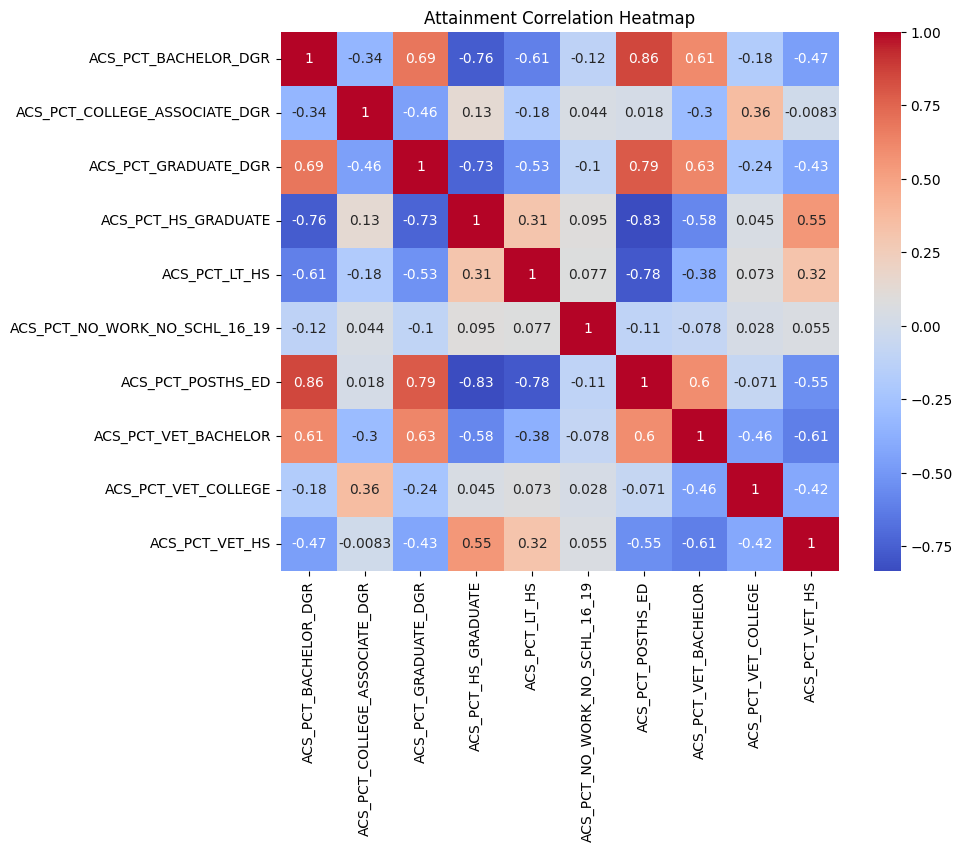

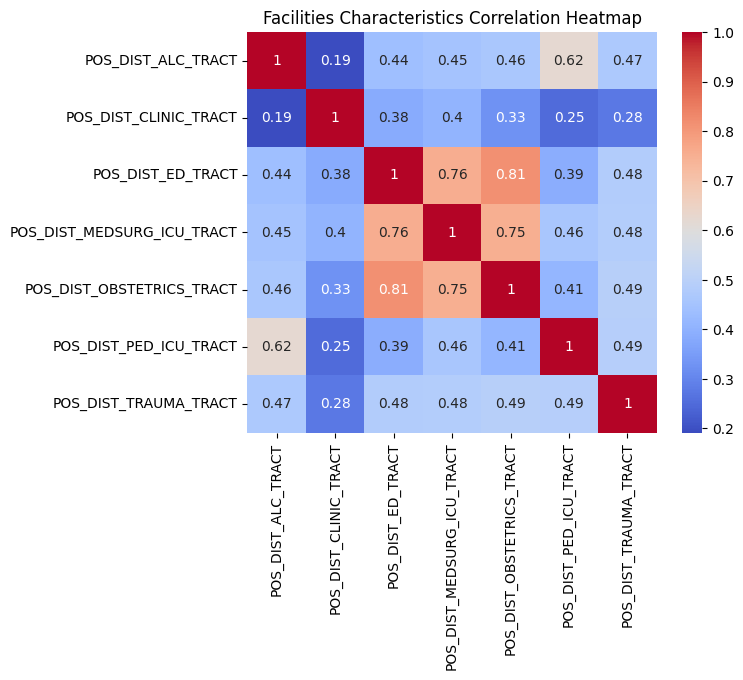

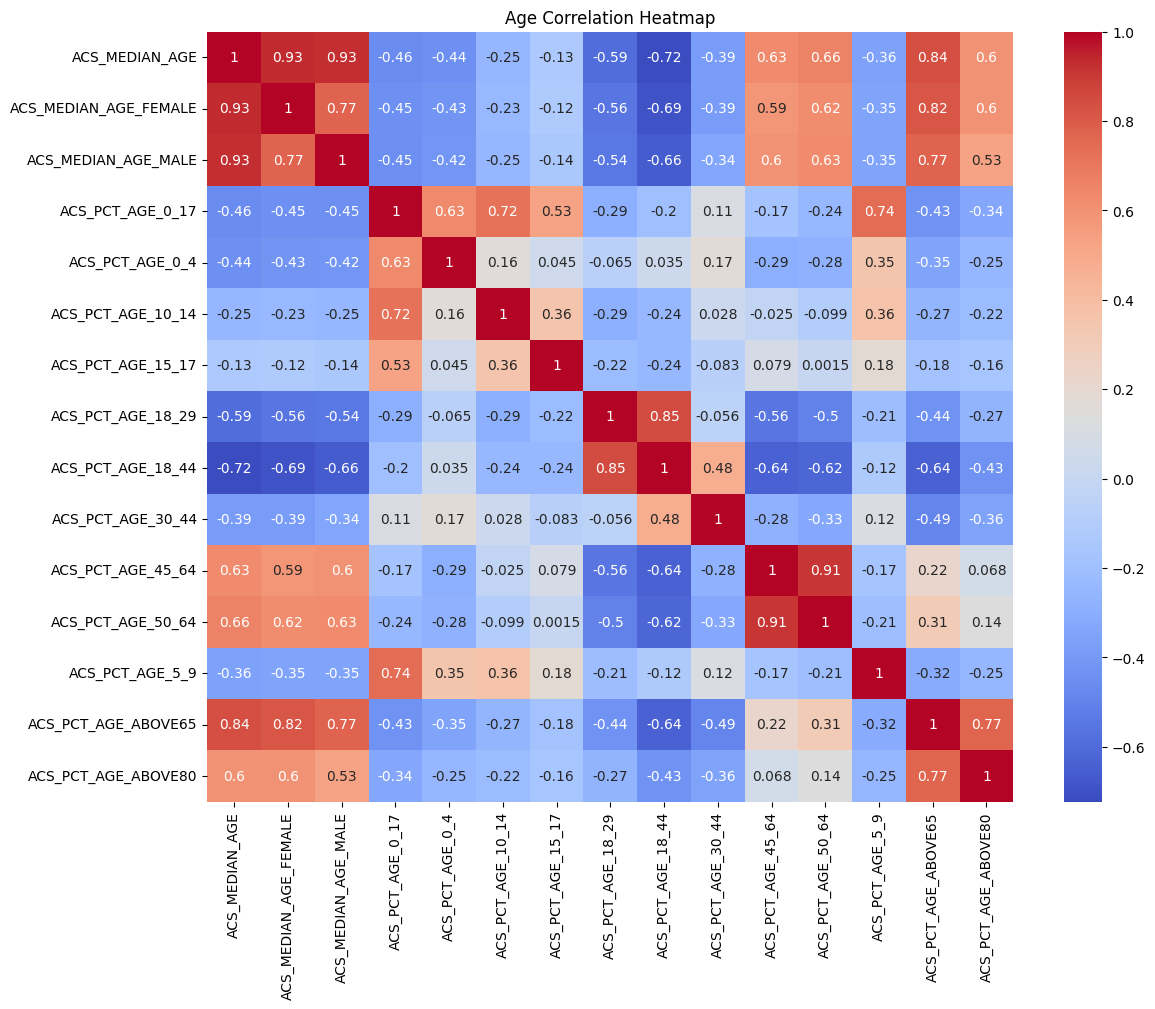

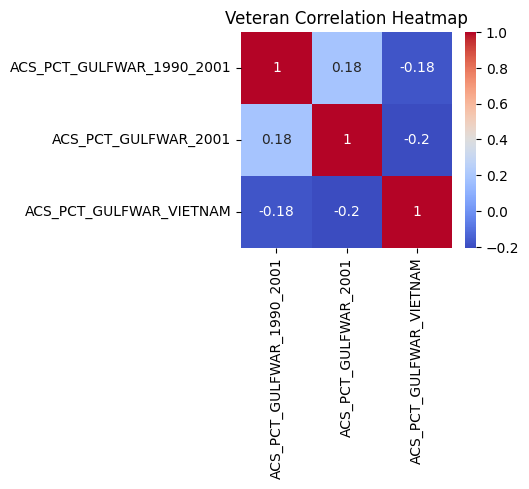

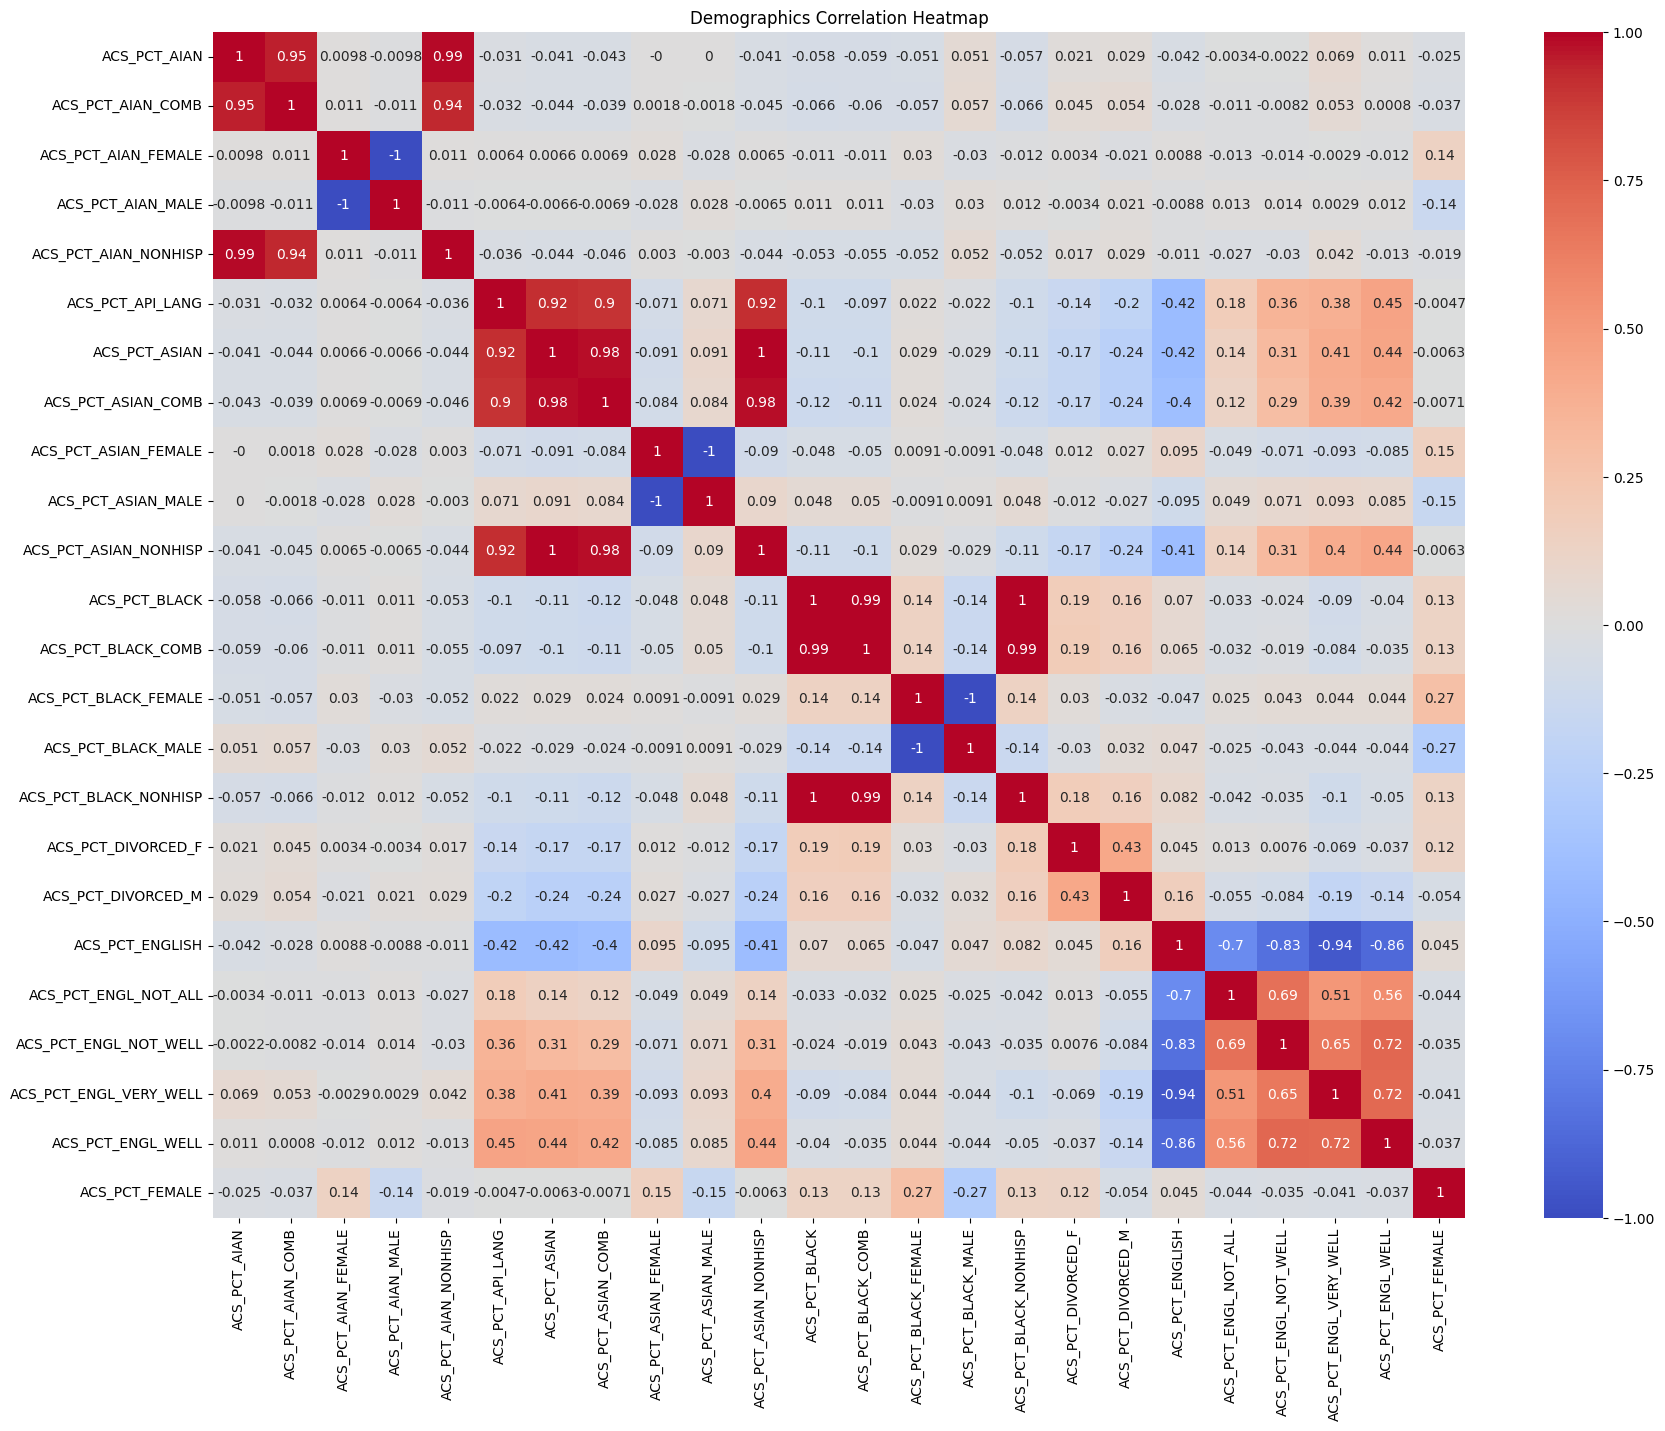

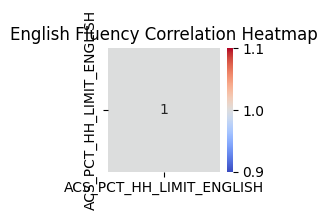

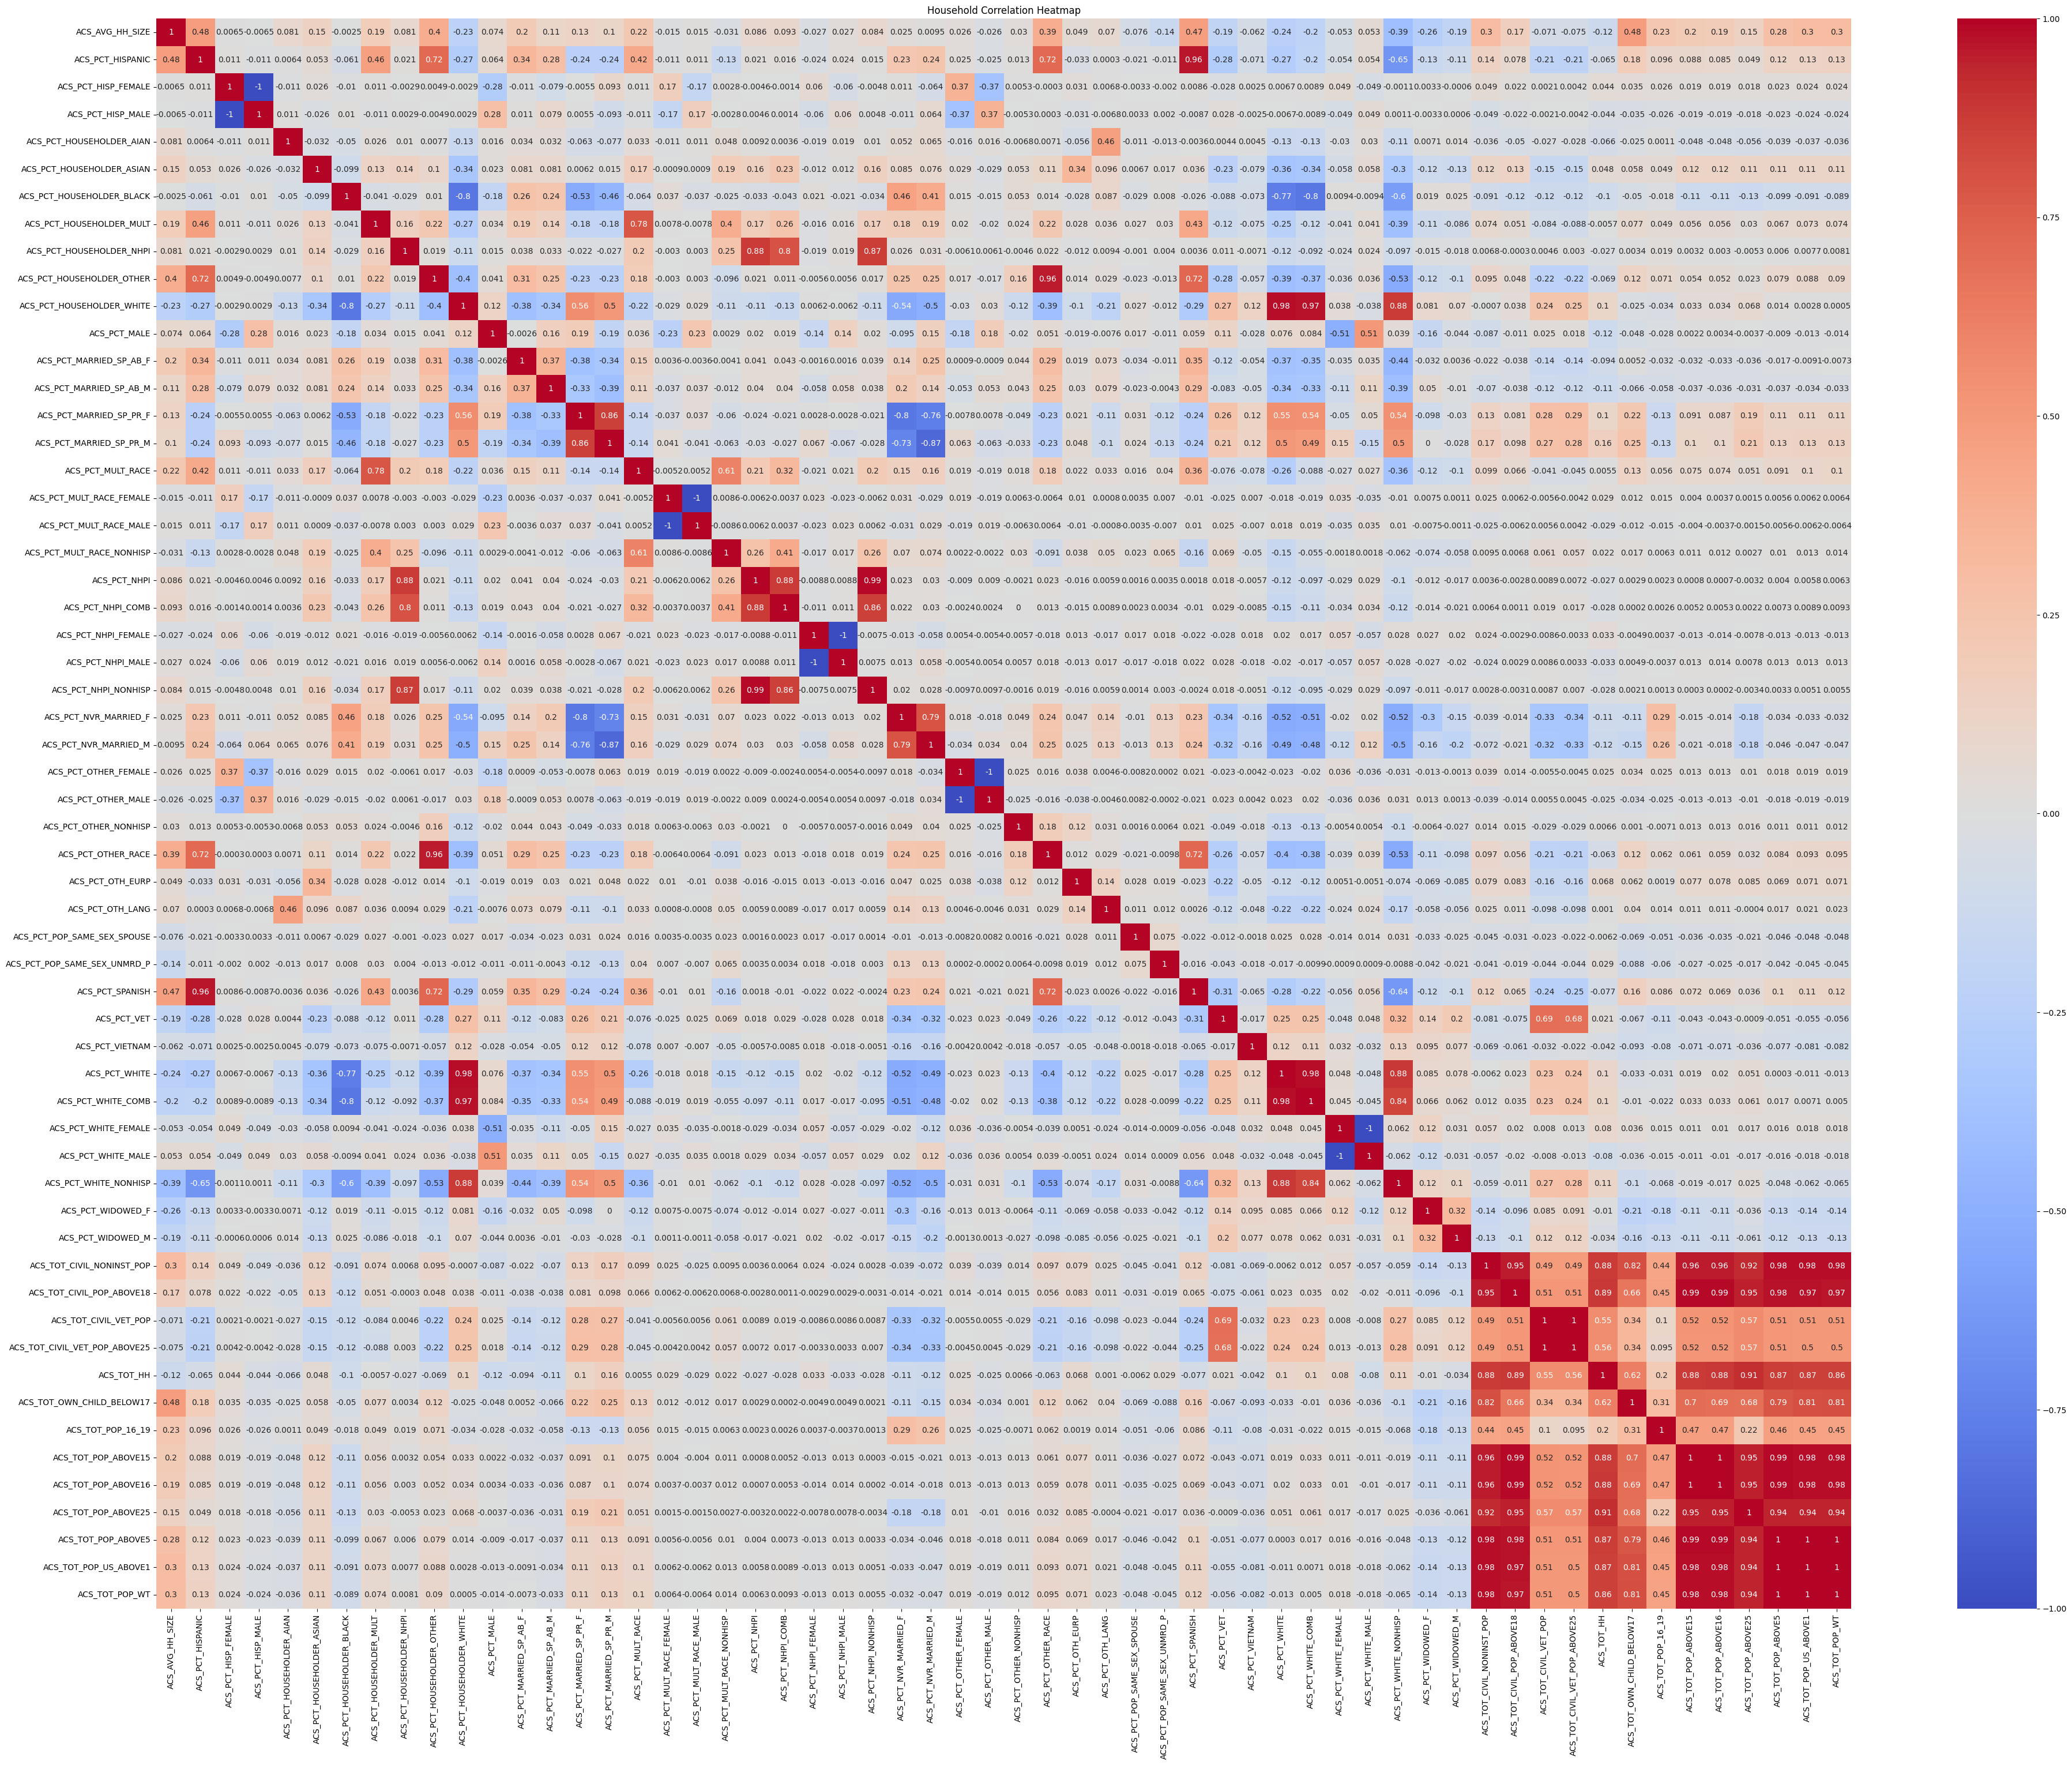

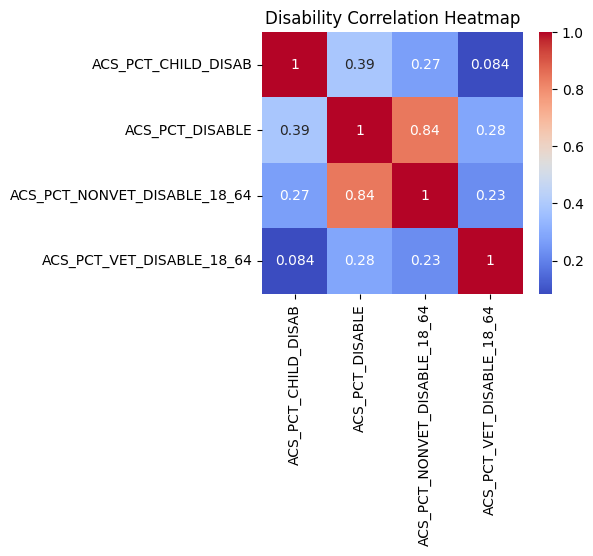

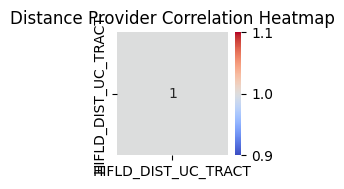

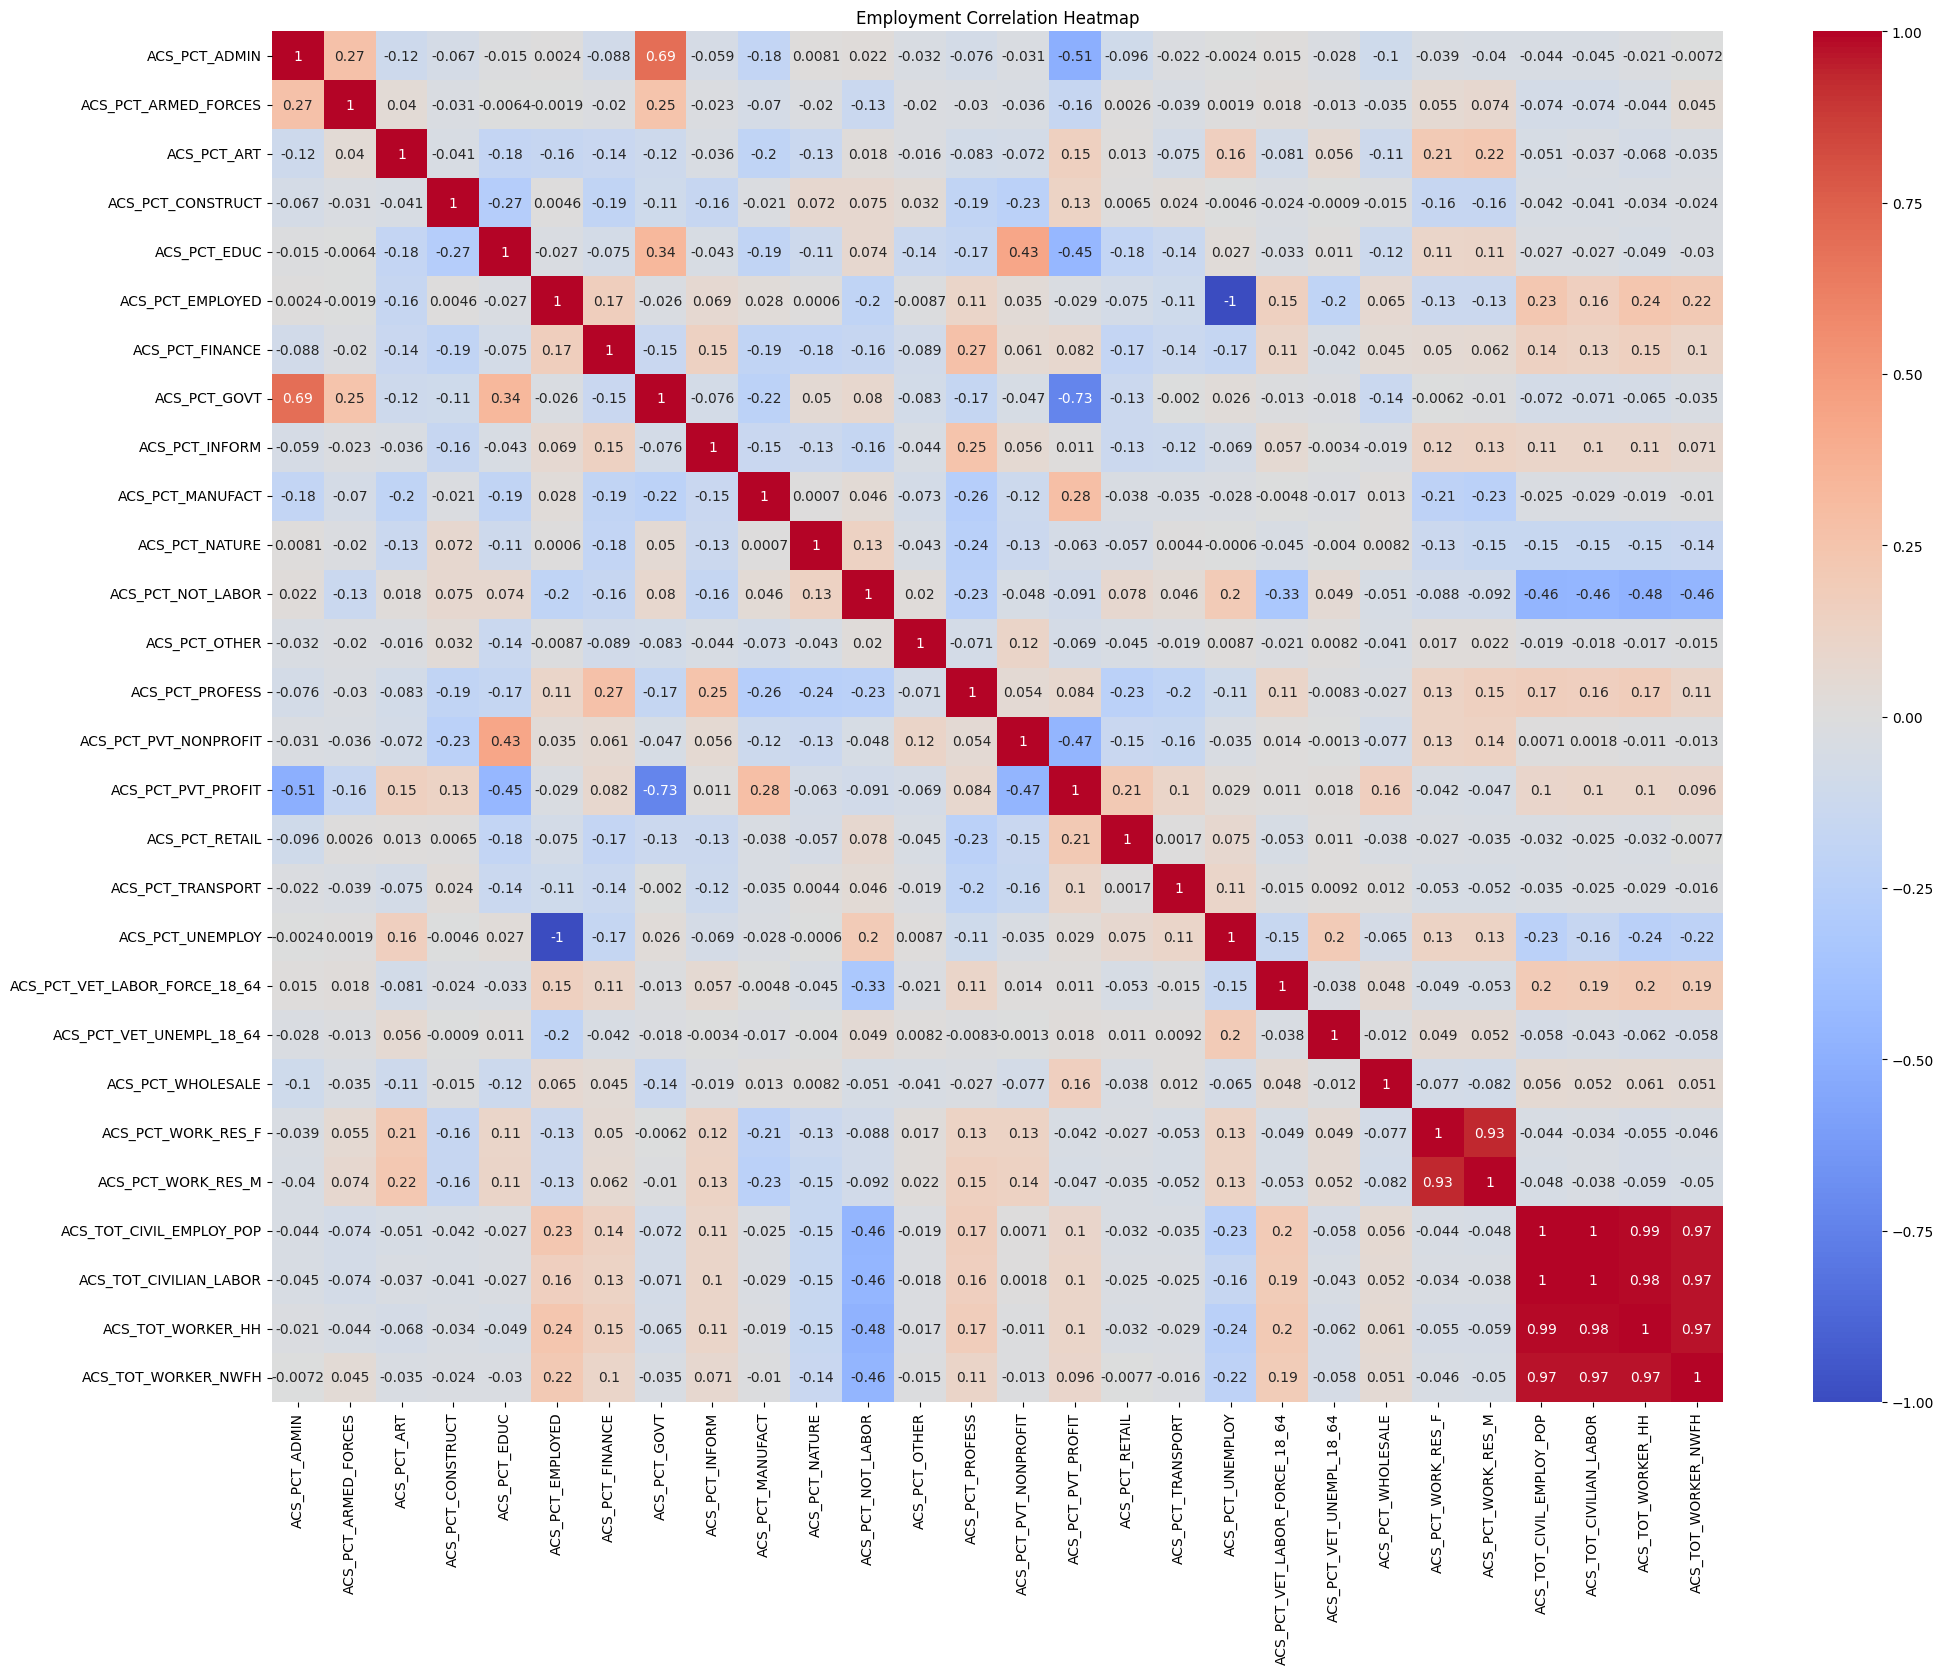

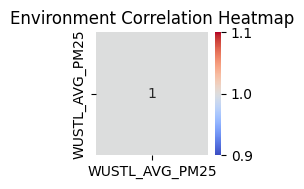

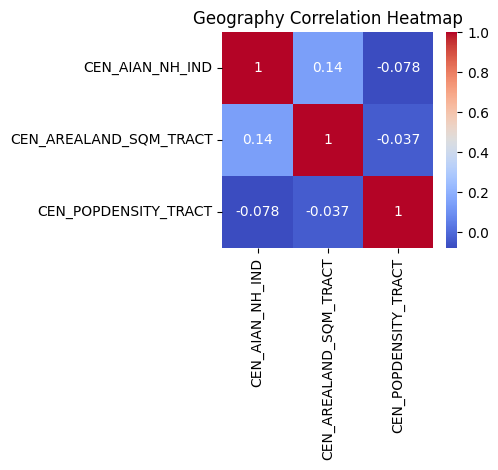

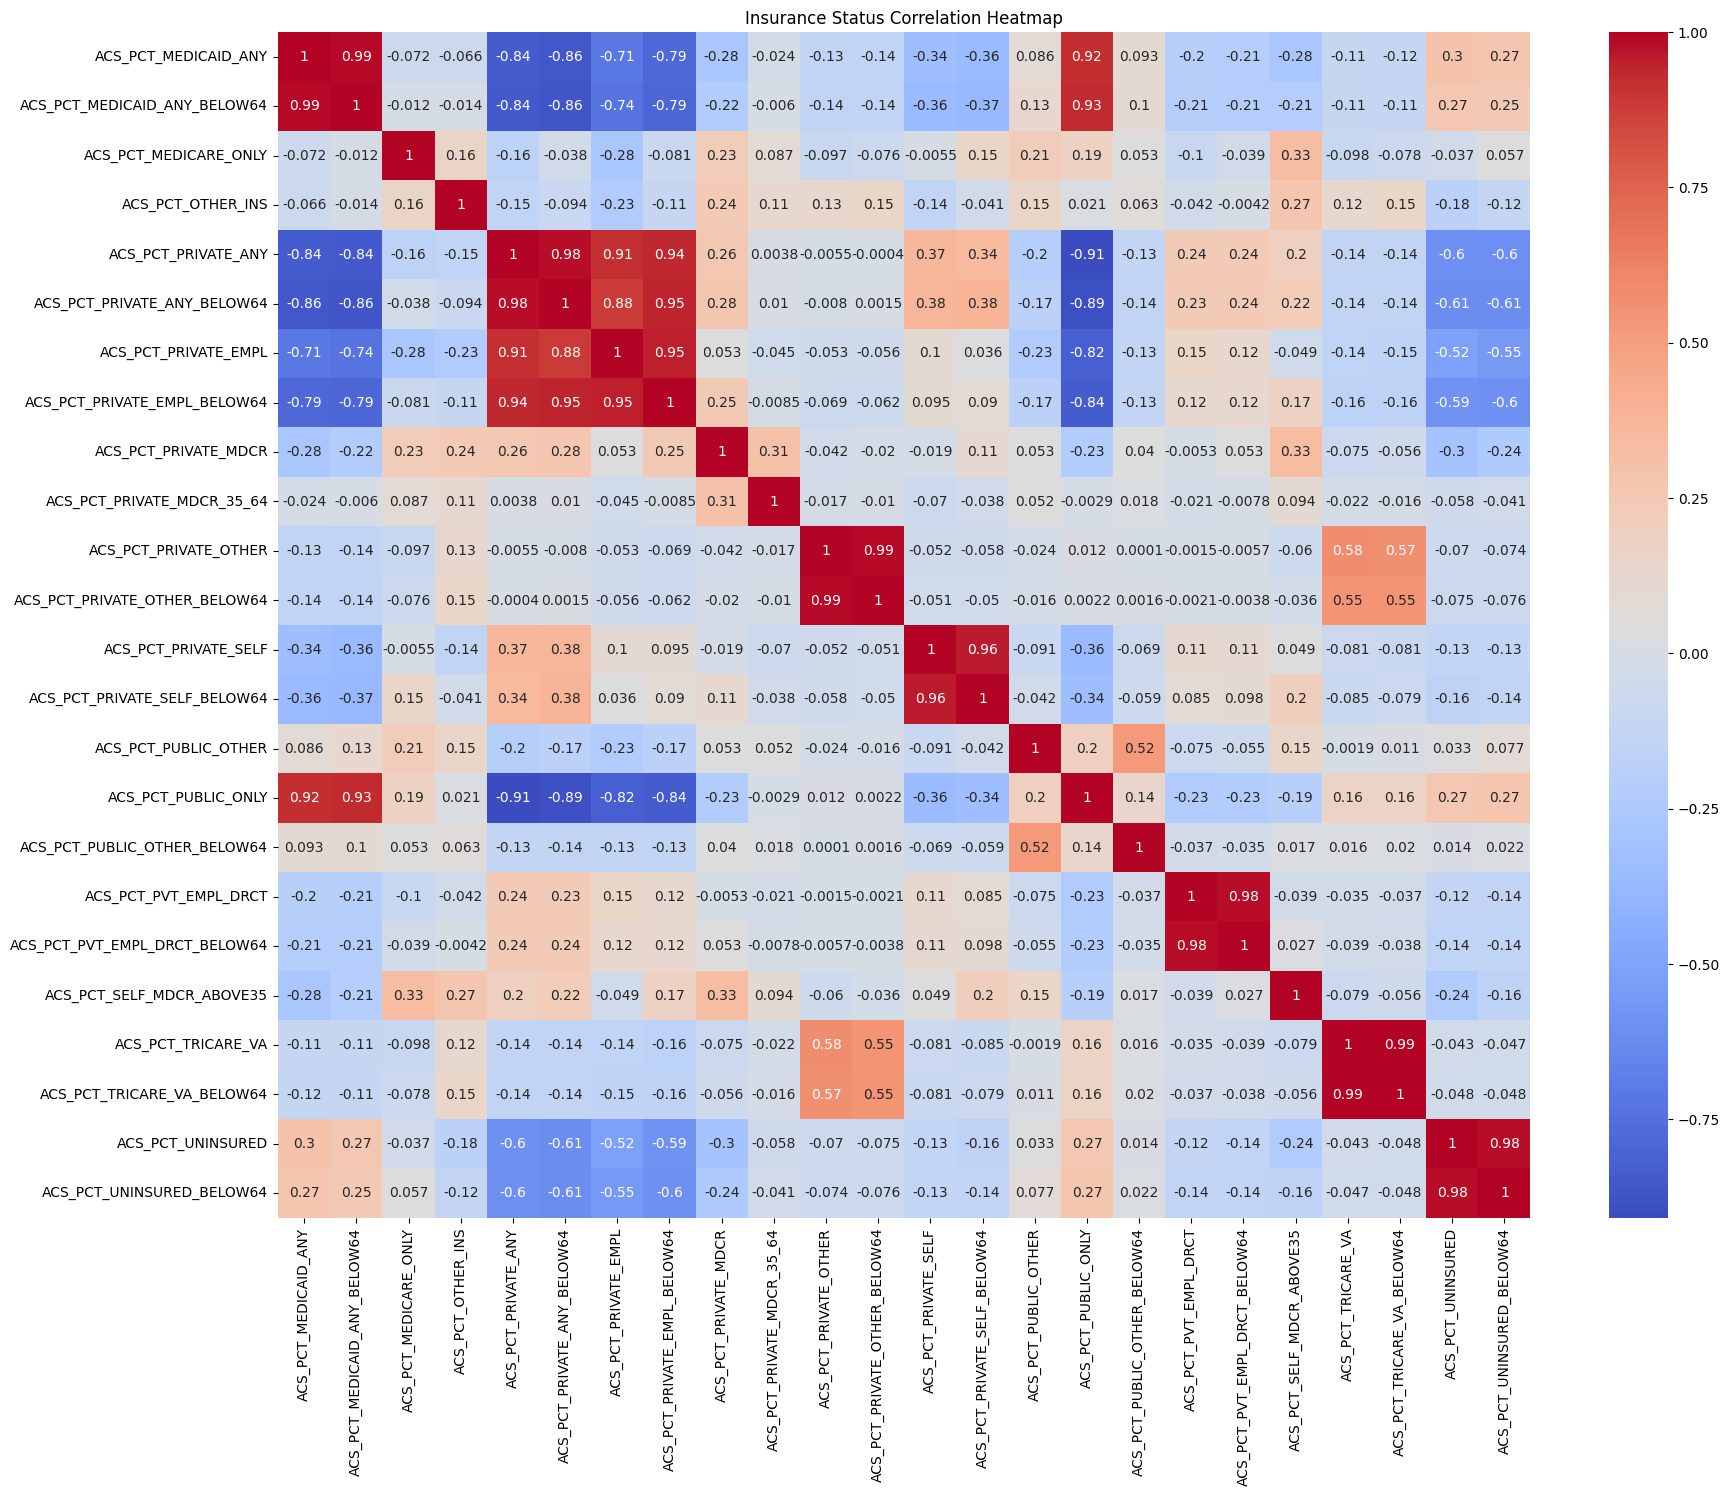

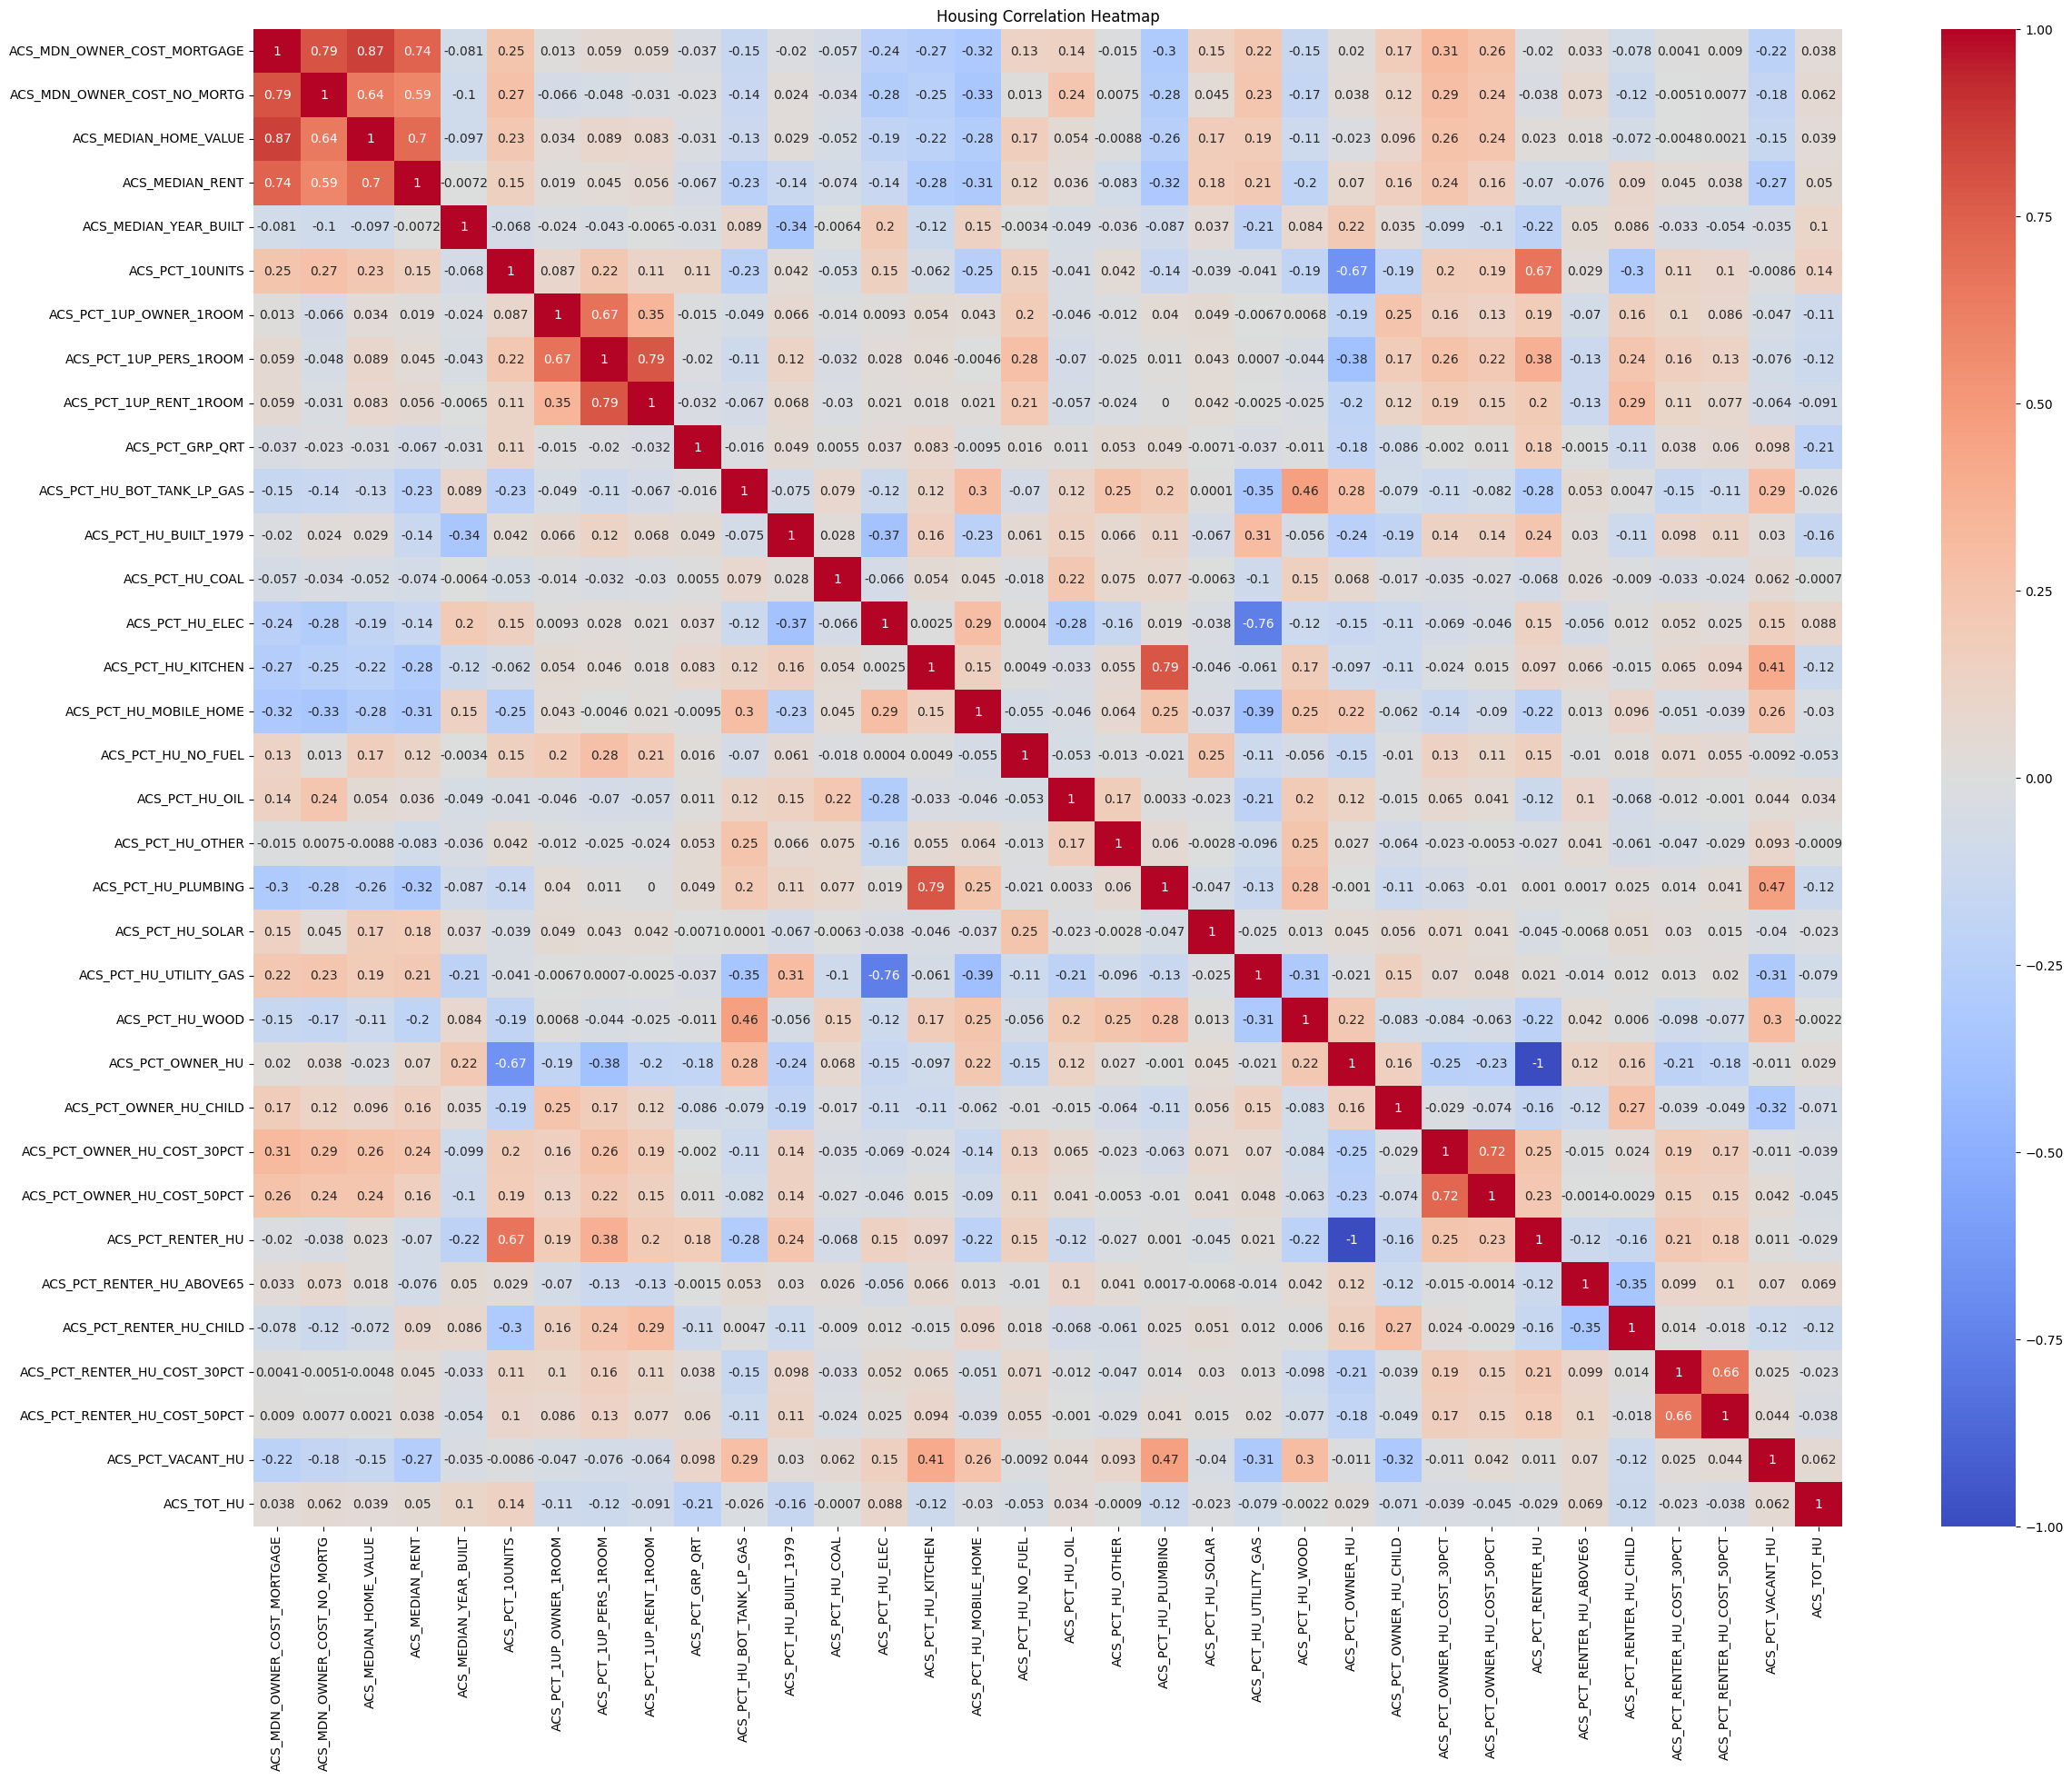

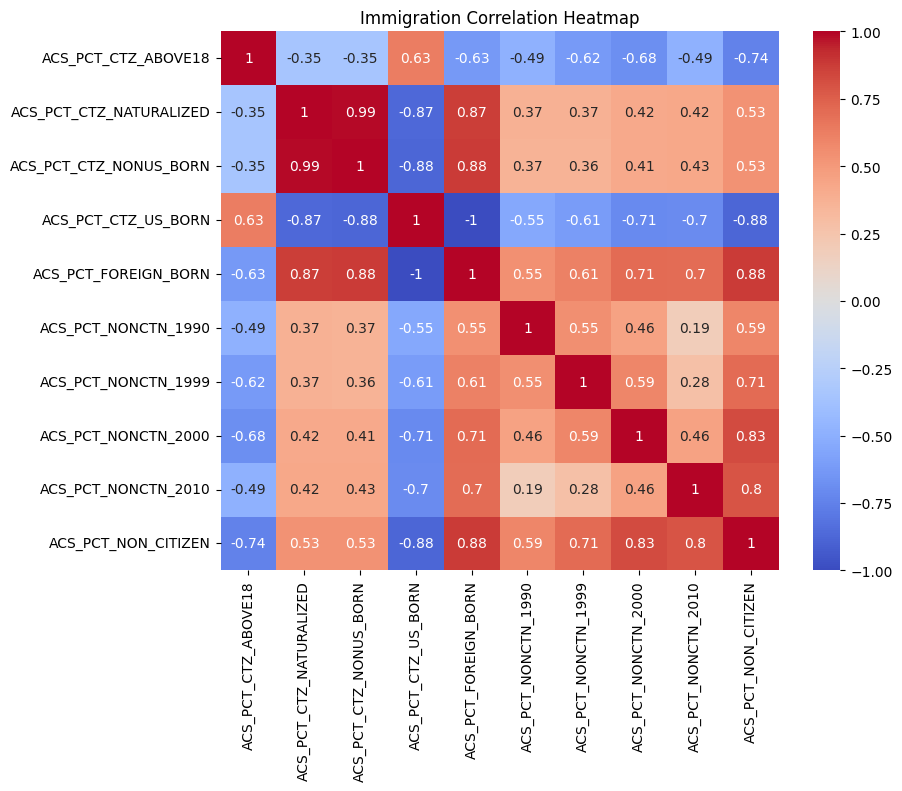

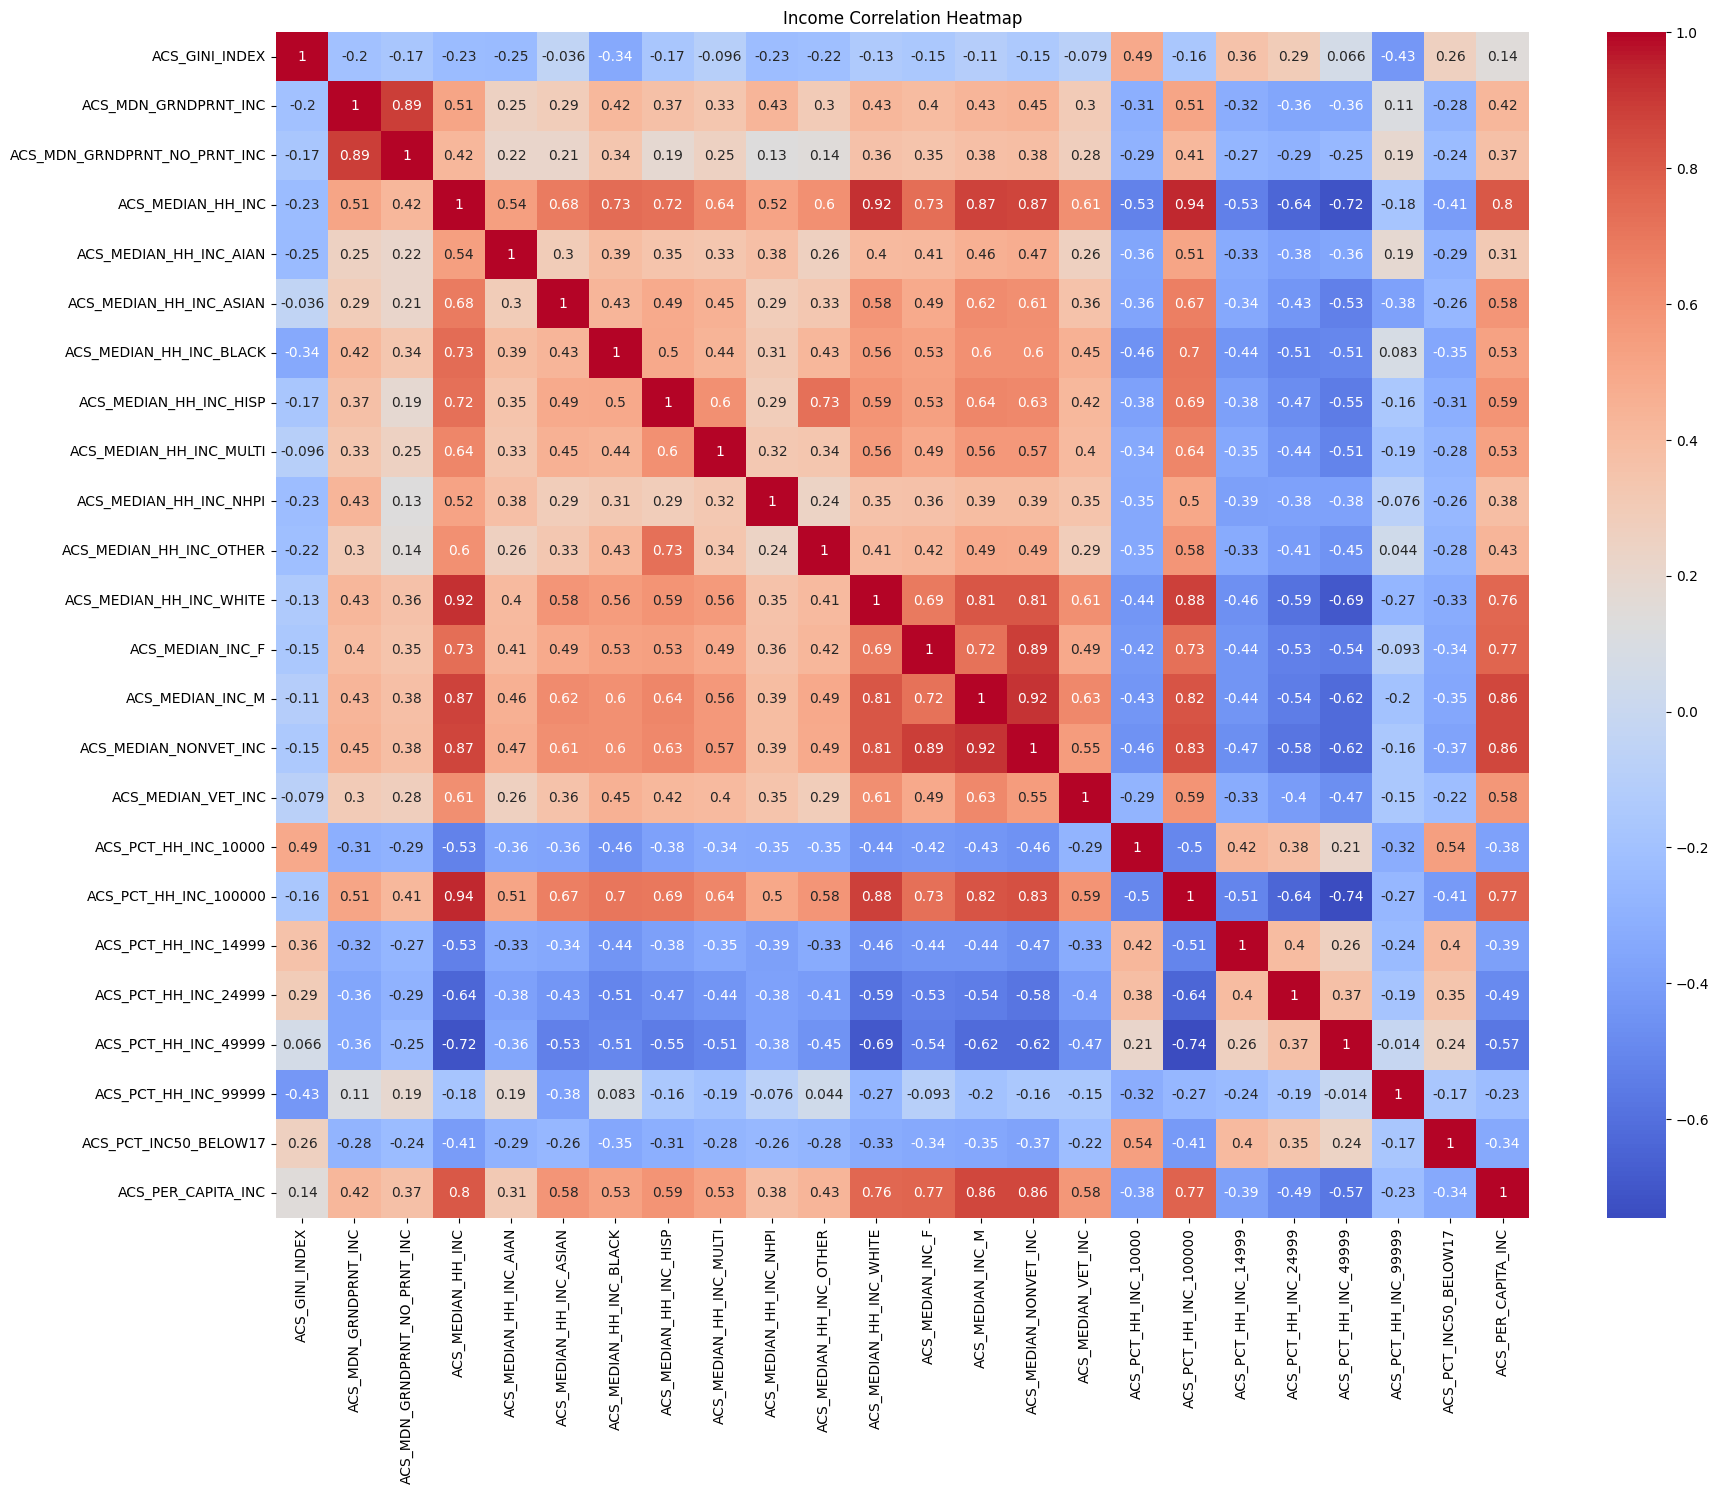

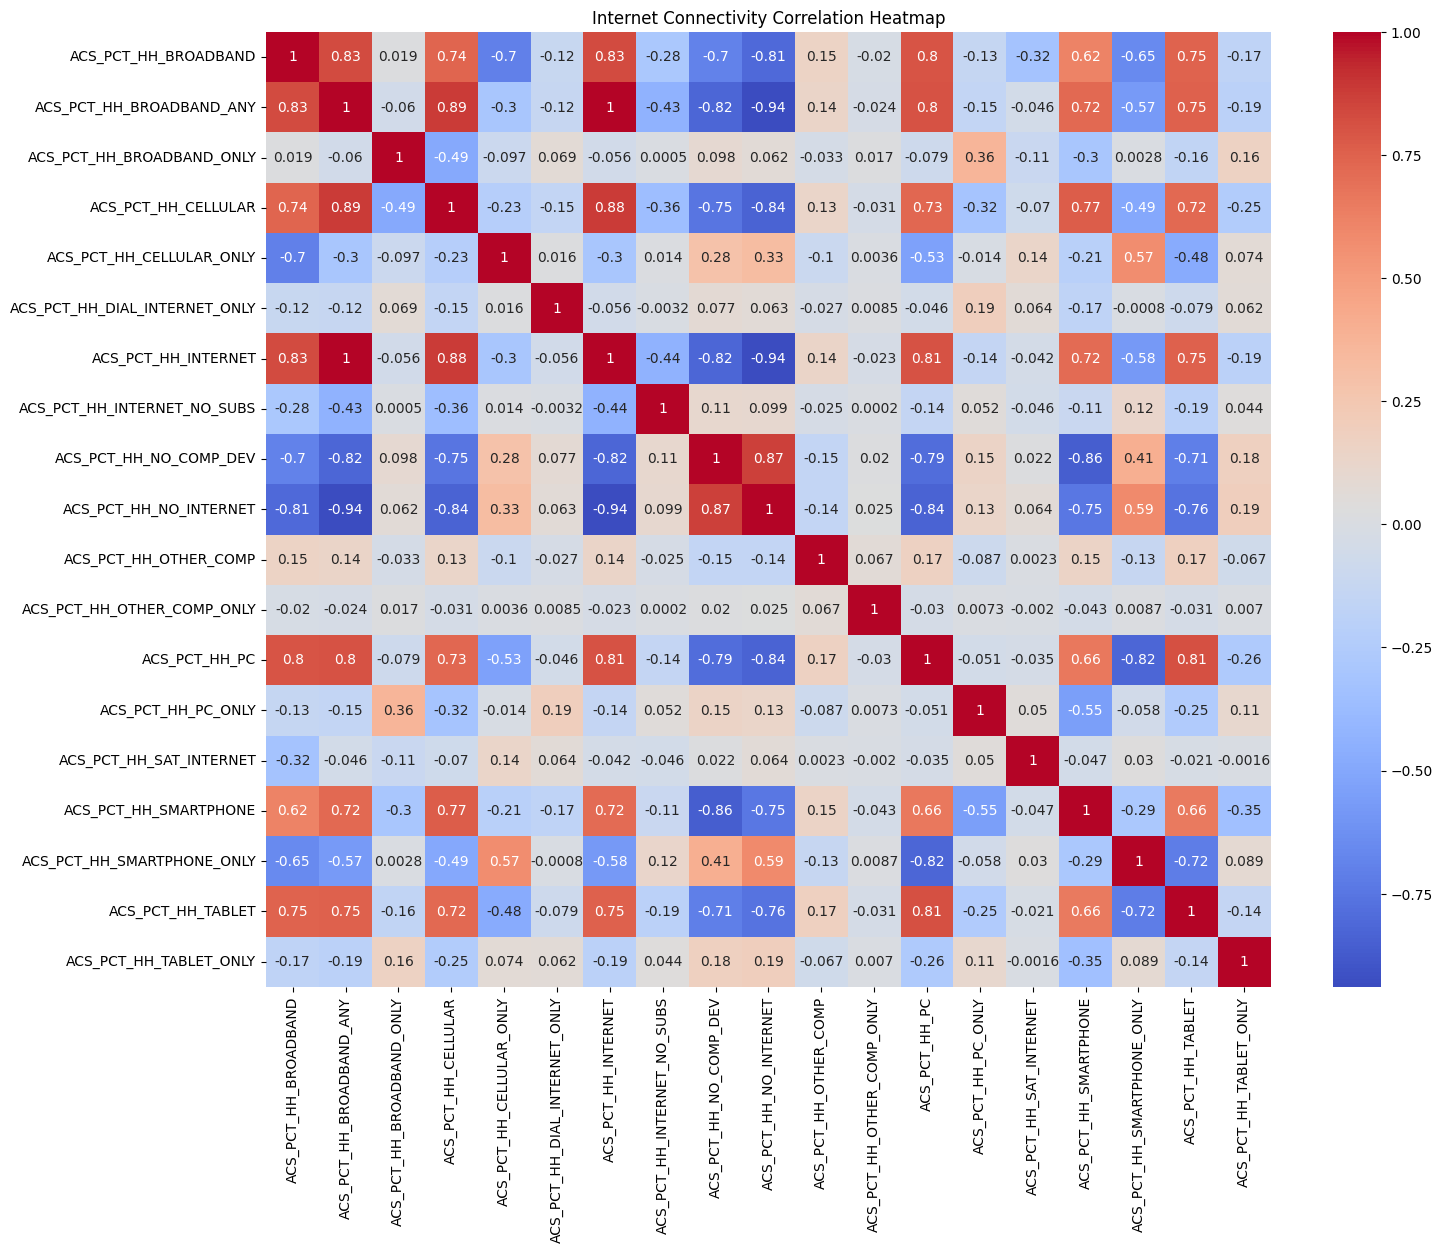

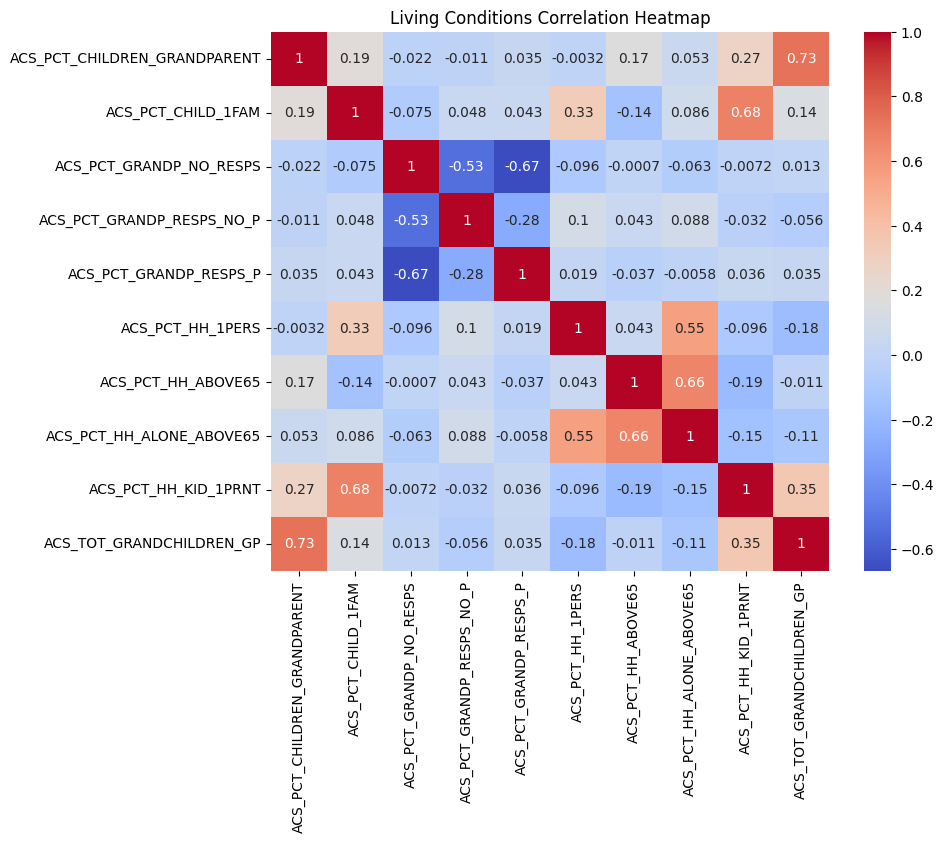

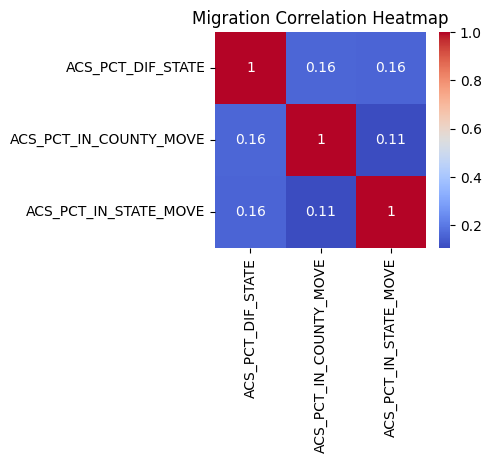

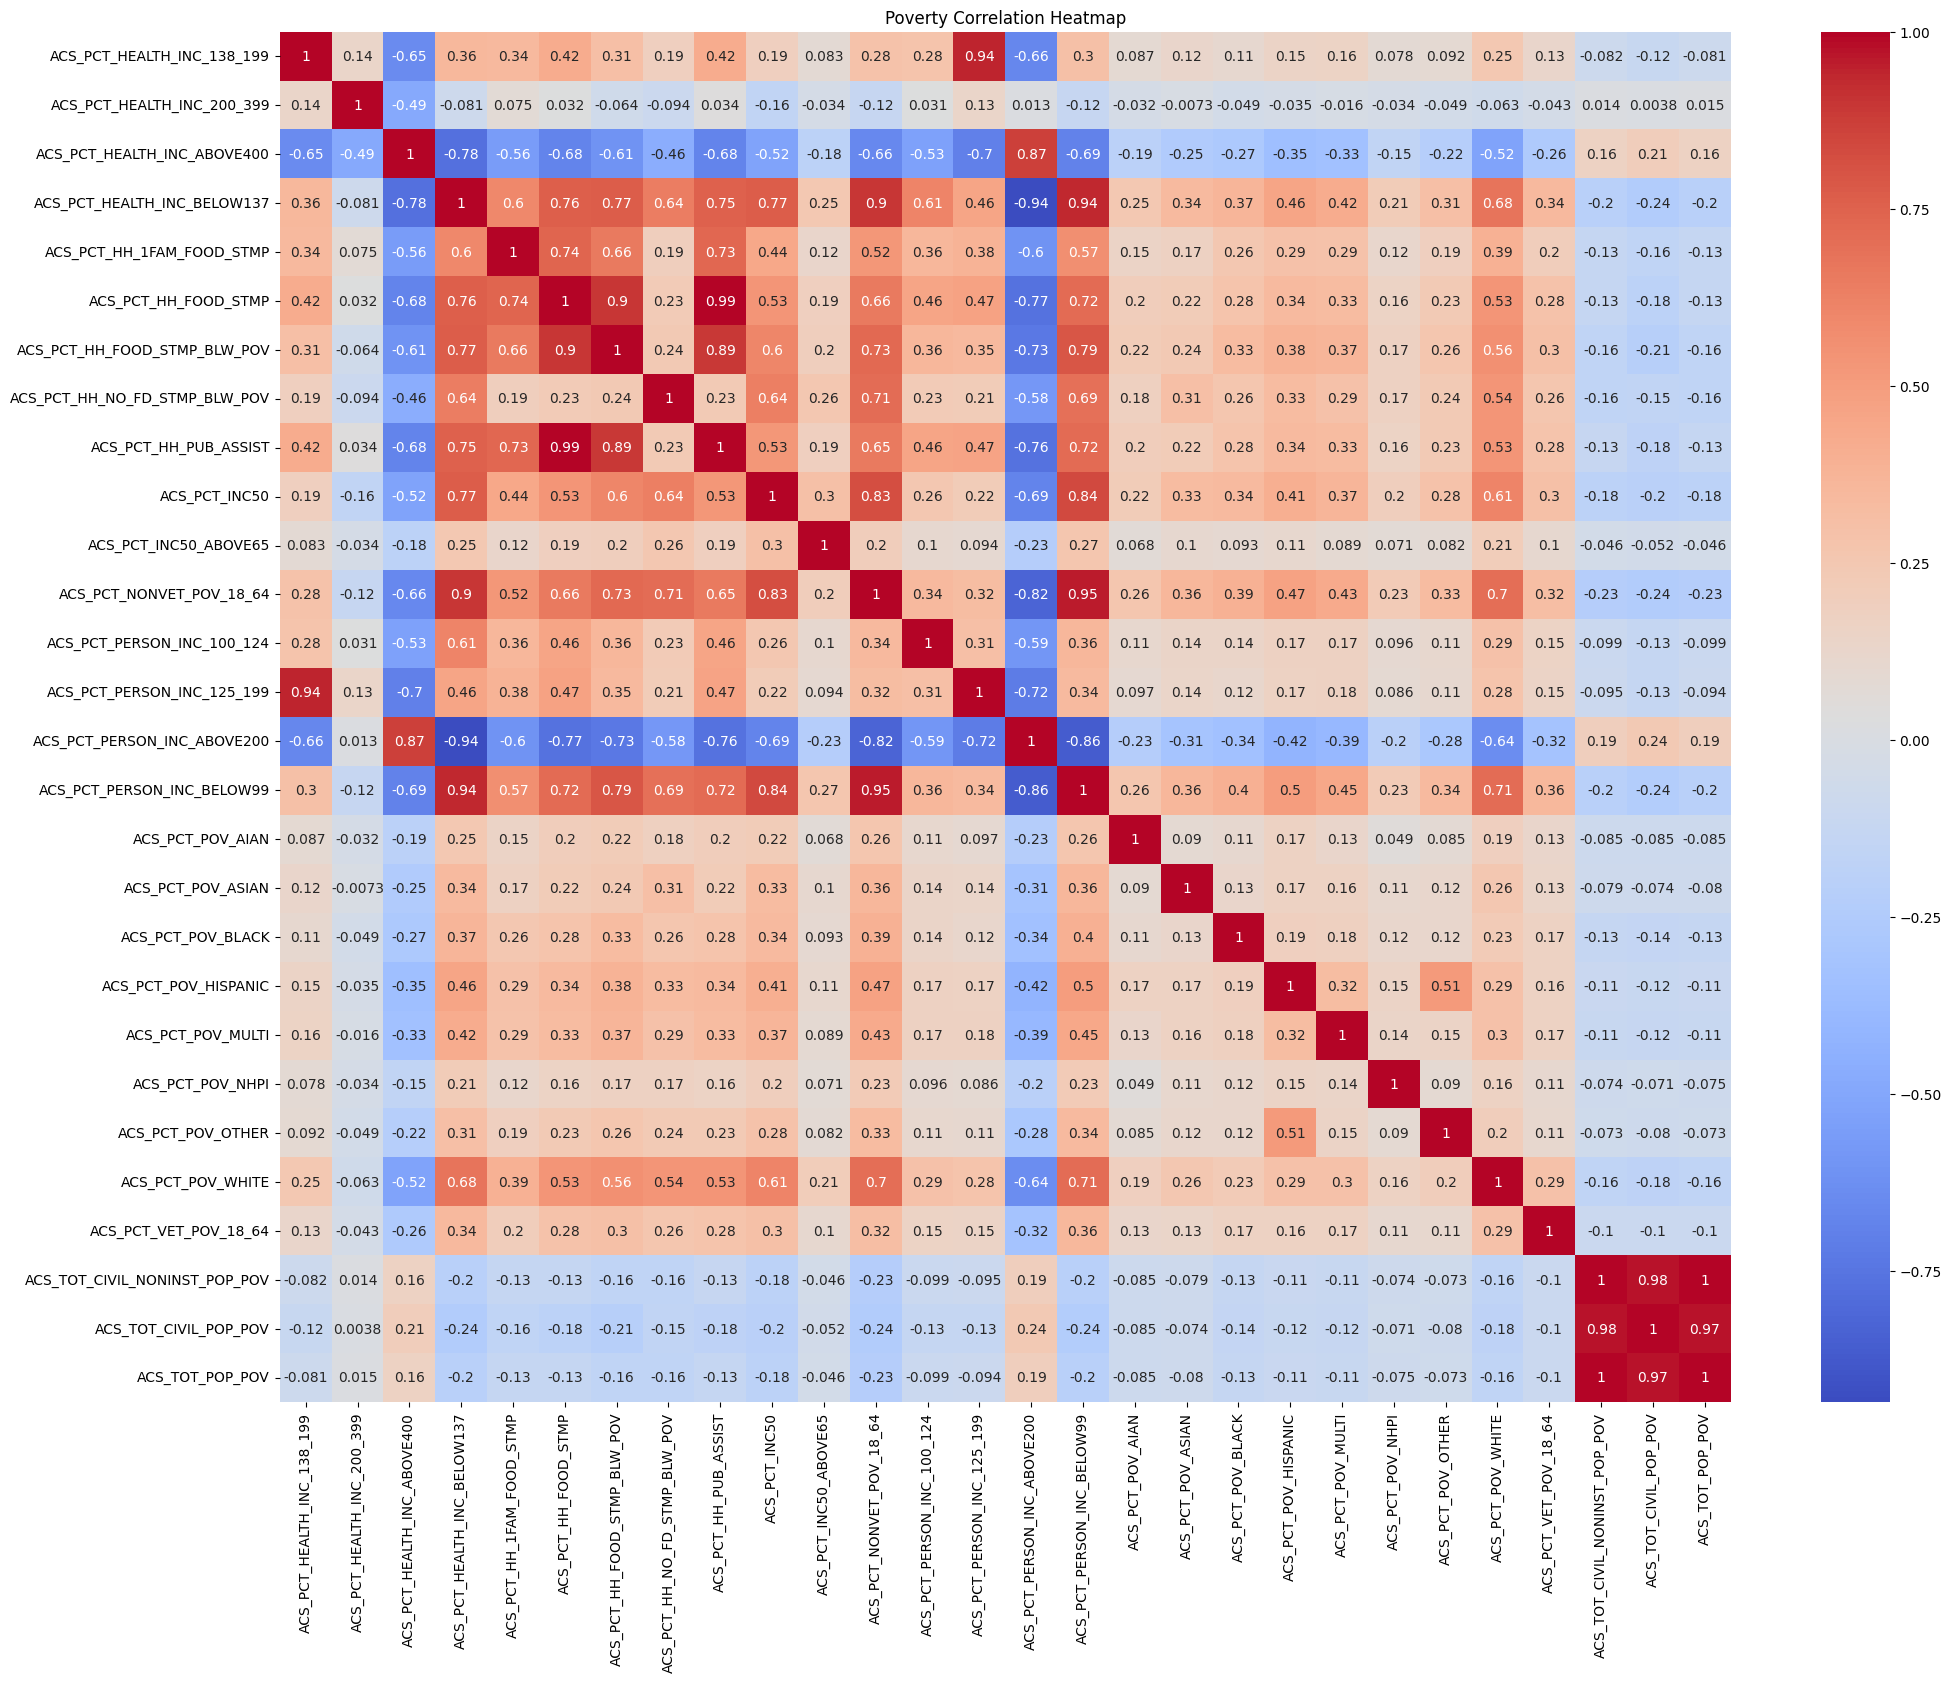

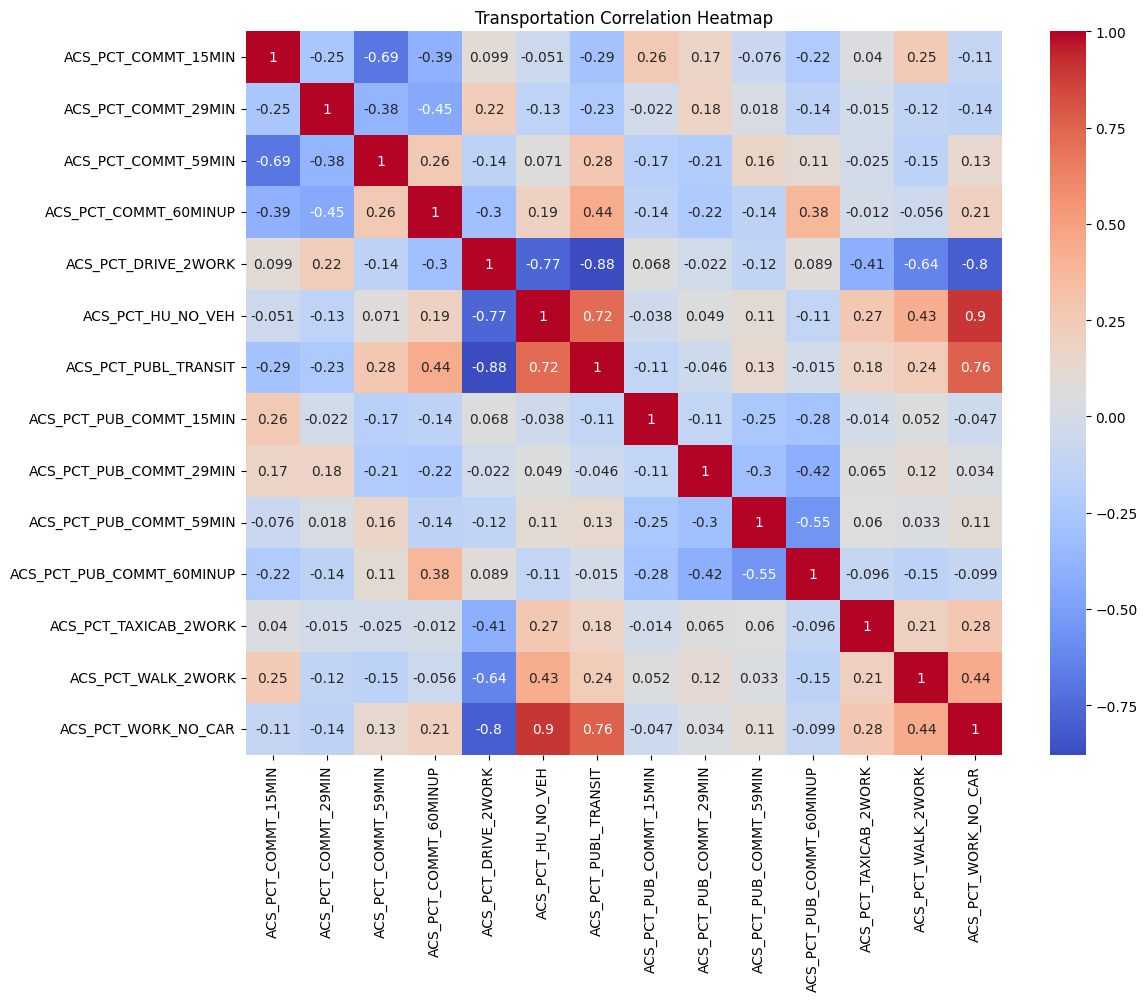

In [16]:
for topic, columns in topics.items():
    temp = df.select(columns).toPandas()
    # Correlation
    corr_matrix = temp.corr().round(4)  
    # Determine figure size based on the matrix size 
    num_columns = corr_matrix.shape[1] 
    fig_width = 1 + num_columns * 0.8 
    fig_height = 1 + num_columns * 0.6 
    # Create the heatmap with dynamic figure size 
    plt.figure(figsize=(fig_width, fig_height)) 
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
    plt.title(f'{topic} Correlation Heatmap') 
    plt.savefig(f'figures/heatmaps/{topic}_CM.png', format='png', dpi=800)
    plt.show()
    

In [17]:
for col_name in df.columns:
    unique_count = df.select(countDistinct(col(col_name))).collect()[0][0]
    print(f"Column: {col_name}", unique_count)


Column: YEAR 1


Column: TRACTFIPS 85528
Column: COUNTYFIPS 3234
Column: STATEFIPS 56
Column: STATE 56
Column: COUNTY 1969
Column: REGION 4
Column: TERRITORY 2


Column: ACS_TOT_POP_WT 8246


Column: ACS_TOT_POP_US_ABOVE1 8188


Column: ACS_TOT_POP_ABOVE5 7787
Column: ACS_TOT_POP_ABOVE15 6826
Column: ACS_TOT_POP_ABOVE16 6732


Column: ACS_TOT_POP_16_19 1474
Column: ACS_TOT_POP_ABOVE25 6044


Column: ACS_TOT_CIVIL_POP_ABOVE18 6579
Column: ACS_TOT_CIVIL_VET_POP_ABOVE25 1147
Column: ACS_TOT_OWN_CHILD_BELOW17 2787
Column: ACS_TOT_CIVILIAN_LABOR 5007
Column: ACS_TOT_CIVIL_EMPLOY_POP 4794


Column: ACS_TOT_WORKER_HH 4743


Column: ACS_TOT_WORKER_NWFH 4436
Column: ACS_TOT_CIVIL_NONINST_POP_POV 8259


Column: ACS_TOT_CIVIL_POP_POV 6505
Column: ACS_TOT_POP_POV 8257
Column: ACS_TOT_GRANDCHILDREN_GP 718
Column: ACS_TOT_HU 3907


Column: ACS_TOT_HH 3524


Column: ACS_AVG_HH_SIZE 473
Column: ACS_TOT_CIVIL_NONINST_POP 8224
Column: ACS_TOT_CIVIL_VET_POP 1159


Column: ACS_PCT_CHILD_DISAB 2864


Column: ACS_PCT_DISABLE 3669


Column: ACS_PCT_NONVET_DISABLE_18_64 3716


Column: ACS_PCT_VET_DISABLE_18_64 6269
Column: ACS_PCT_FEMALE 3753


Column: ACS_PCT_MALE 3754


Column: ACS_PCT_CTZ_ABOVE18 6403
Column: ACS_PCT_CTZ_NATURALIZED 4013
Column: ACS_PCT_CTZ_NONUS_BORN 4149


Column: ACS_PCT_CTZ_US_BORN 6359


Column: ACS_PCT_FOREIGN_BORN 6360


Column: ACS_PCT_NON_CITIZEN 4059
Column: ACS_PCT_NONCTN_1990 1166
Column: ACS_PCT_NONCTN_1999 1347


Column: ACS_PCT_NONCTN_2000 1788
Column: ACS_PCT_NONCTN_2010 2589


Column: ACS_PCT_API_LANG 3664
Column: ACS_PCT_ENGL_NOT_ALL 1971


Column: ACS_PCT_ENGL_NOT_WELL 2543
Column: ACS_PCT_ENGL_VERY_WELL 5581


Column: ACS_PCT_ENGL_WELL 2653


Column: ACS_PCT_ENGLISH 8903


Column: ACS_PCT_HH_LIMIT_ENGLISH 4034
Column: ACS_PCT_OTH_EURP 3228


Column: ACS_PCT_OTH_LANG 1919
Column: ACS_PCT_SPANISH 7967
Column: ACS_PCT_GULFWAR_1990_2001 6773


Column: ACS_PCT_GULFWAR_2001 7124


Column: ACS_PCT_GULFWAR_VIETNAM 5733


Column: ACS_PCT_VET 2764
Column: ACS_PCT_VIETNAM 7766


Column: ACS_MEDIAN_AGE 657
Column: ACS_MEDIAN_AGE_FEMALE 665


Column: ACS_MEDIAN_AGE_MALE 697


Column: ACS_PCT_AGE_0_4 1969


Column: ACS_PCT_AGE_5_9 1812
Column: ACS_PCT_AGE_10_14 1826


Column: ACS_PCT_AGE_15_17 1334


Column: ACS_PCT_AGE_0_17 4448


Column: ACS_PCT_AGE_18_29 5522


Column: ACS_PCT_AGE_18_44 7040


Column: ACS_PCT_AGE_30_44 4155


Column: ACS_PCT_AGE_45_64 4244


Column: ACS_PCT_AGE_50_64 3745
Column: ACS_PCT_AGE_ABOVE65 5138


Column: ACS_PCT_AGE_ABOVE80 2281


Column: ACS_PCT_AIAN 1792
Column: ACS_PCT_AIAN_FEMALE 4283
Column: ACS_PCT_AIAN_MALE 4288
Column: ACS_PCT_AIAN_NONHISP 1686
Column: ACS_PCT_ASIAN 4862


Column: ACS_PCT_ASIAN_FEMALE 6826
Column: ACS_PCT_ASIAN_MALE 6826


Column: ACS_PCT_ASIAN_NONHISP 4844
Column: ACS_PCT_BLACK 8520


Column: ACS_PCT_BLACK_FEMALE 7834


Column: ACS_PCT_BLACK_MALE 7829


Column: ACS_PCT_BLACK_NONHISP 8476


Column: ACS_PCT_HISP_FEMALE 7711


Column: ACS_PCT_HISP_MALE 7711


Column: ACS_PCT_HISPANIC 8858
Column: ACS_PCT_MULT_RACE 2772


Column: ACS_PCT_MULT_RACE_FEMALE 8475


Column: ACS_PCT_MULT_RACE_MALE 8478
Column: ACS_PCT_MULT_RACE_NONHISP 1955
Column: ACS_PCT_NHPI 915
Column: ACS_PCT_NHPI_FEMALE 1906
Column: ACS_PCT_NHPI_MALE 1908
Column: ACS_PCT_NHPI_NONHISP 897


Column: ACS_PCT_OTHER_FEMALE 7366


Column: ACS_PCT_OTHER_MALE 7366
Column: ACS_PCT_OTHER_NONHISP 980
Column: ACS_PCT_OTHER_RACE 4565


Column: ACS_PCT_WHITE 9747


Column: ACS_PCT_WHITE_FEMALE 5293


Column: ACS_PCT_WHITE_MALE 5294


Column: ACS_PCT_WHITE_NONHISP 9966


Column: ACS_PCT_HOUSEHOLDER_WHITE 9617
Column: ACS_PCT_HOUSEHOLDER_BLACK 8447
Column: ACS_PCT_HOUSEHOLDER_AIAN 1677


Column: ACS_PCT_HOUSEHOLDER_ASIAN 4677
Column: ACS_PCT_HOUSEHOLDER_NHPI 816


Column: ACS_PCT_HOUSEHOLDER_OTHER 4186
Column: ACS_PCT_HOUSEHOLDER_MULT 2532
Column: ACS_PCT_AIAN_COMB 2307
Column: ACS_PCT_ASIAN_COMB 5228


Column: ACS_PCT_BLACK_COMB 8684


Column: ACS_PCT_NHPI_COMB 1240


Column: ACS_PCT_WHITE_COMB 9595


Column: ACS_PCT_HH_NO_COMP_DEV 3813
Column: ACS_PCT_HH_SMARTPHONE 4937


Column: ACS_PCT_HH_SMARTPHONE_ONLY 3897


Column: ACS_PCT_HH_TABLET 7356
Column: ACS_PCT_HH_TABLET_ONLY 1069


Column: ACS_PCT_HH_PC 6822


Column: ACS_PCT_HH_PC_ONLY 2099


Column: ACS_PCT_HH_OTHER_COMP 2023
Column: ACS_PCT_HH_OTHER_COMP_ONLY 299
Column: ACS_PCT_HH_INTERNET 5430
Column: ACS_PCT_HH_INTERNET_NO_SUBS 2205


Column: ACS_PCT_HH_BROADBAND 8008


Column: ACS_PCT_HH_BROADBAND_ONLY 3258


Column: ACS_PCT_HH_BROADBAND_ANY 5462


Column: ACS_PCT_HH_CELLULAR 6692


Column: ACS_PCT_HH_CELLULAR_ONLY 3999
Column: ACS_PCT_HH_NO_INTERNET 4886


Column: ACS_PCT_HH_SAT_INTERNET 3308
Column: ACS_PCT_HH_DIAL_INTERNET_ONLY 646


Column: ACS_PCT_CHILD_1FAM 9148


Column: ACS_PCT_CHILDREN_GRANDPARENT 4531


Column: ACS_PCT_GRANDP_RESPS_NO_P 5799
Column: ACS_PCT_GRANDP_RESPS_P 6888


Column: ACS_PCT_GRANDP_NO_RESPS 7458


Column: ACS_PCT_HH_KID_1PRNT 5401
Column: ACS_PCT_DIVORCED_F 3848
Column: ACS_PCT_DIVORCED_M 3529


Column: ACS_PCT_MARRIED_SP_AB_F 2281
Column: ACS_PCT_MARRIED_SP_AB_M 2357


Column: ACS_PCT_MARRIED_SP_PR_F 7615


Column: ACS_PCT_MARRIED_SP_PR_M 7851


Column: ACS_PCT_NVR_MARRIED_F 7438


Column: ACS_PCT_NVR_MARRIED_M 7650


Column: ACS_PCT_WIDOWED_F 3126
Column: ACS_PCT_WIDOWED_M 1738
Column: ACS_PCT_POP_SAME_SEX_UNMRD_P 448
Column: ACS_PCT_POP_SAME_SEX_SPOUSE 476
Column: ACS_PCT_ADMIN 2642
Column: ACS_PCT_ARMED_FORCES 1283


Column: ACS_PCT_ART 3579


Column: ACS_PCT_CONSTRUCT 2886
Column: ACS_PCT_EDUC 5014


Column: ACS_PCT_EMPLOYED 2849


Column: ACS_PCT_FINANCE 2723


Column: ACS_PCT_GOVT 4416


Column: ACS_PCT_INFORM 1553


Column: ACS_PCT_MANUFACT 3851
Column: ACS_PCT_NATURE 2732
Column: ACS_PCT_NOT_LABOR 6503
Column: ACS_PCT_OTHER 2078
Column: ACS_PCT_PROFESS 3774


Column: ACS_PCT_PVT_NONPROFIT 3169


Column: ACS_PCT_PVT_PROFIT 5599


Column: ACS_PCT_RETAIL 3180


Column: ACS_PCT_TRANSPORT 2473


Column: ACS_PCT_UNEMPLOY 2848


Column: ACS_PCT_VET_LABOR_FORCE_18_64 6872
Column: ACS_PCT_VET_UNEMPL_18_64 3421
Column: ACS_PCT_WHOLESALE 1533


Column: ACS_PCT_WORK_RES_F 9889


Column: ACS_PCT_WORK_RES_M 9816
Column: ACS_GINI_INDEX 84
Column: ACS_MDN_GRNDPRNT_NO_PRNT_INC 1673
Column: ACS_MDN_GRNDPRNT_INC 6348
Column: ACS_MEDIAN_HH_INC_AIAN 2325
Column: ACS_MEDIAN_HH_INC_ASIAN 15142


Column: ACS_MEDIAN_HH_INC_BLACK 22799


Column: ACS_MEDIAN_HH_INC_HISP 26435


Column: ACS_MEDIAN_HH_INC_MULTI 15983
Column: ACS_MEDIAN_HH_INC_NHPI 353
Column: ACS_MEDIAN_HH_INC_OTHER 12173
Column: ACS_MEDIAN_HH_INC_WHITE 41125


Column: ACS_MEDIAN_HH_INC 46989
Column: ACS_MEDIAN_INC_F 31143


Column: ACS_MEDIAN_INC_M 39866


Column: ACS_MEDIAN_NONVET_INC 37549


Column: ACS_MEDIAN_VET_INC 25456
Column: ACS_PCT_INC50_ABOVE65 2837


Column: ACS_PCT_INC50_BELOW17 5163


Column: ACS_PCT_HEALTH_INC_BELOW137 6863


Column: ACS_PCT_HEALTH_INC_138_199 3618


Column: ACS_PCT_HEALTH_INC_200_399 5609
Column: ACS_PCT_HEALTH_INC_ABOVE400 9031


Column: ACS_PCT_HH_INC_10000 3503


Column: ACS_PCT_HH_INC_100000 8278


Column: ACS_PCT_HH_INC_14999 2451


Column: ACS_PCT_HH_INC_24999 3290
Column: ACS_PCT_HH_INC_49999 4898
Column: ACS_PCT_HH_INC_99999 5241
Column: ACS_PCT_INC50 3648


Column: ACS_PCT_NONVET_POV_18_64 5531


Column: ACS_PCT_VET_POV_18_64 4757


Column: ACS_PCT_PERSON_INC_100_124 2416
Column: ACS_PCT_PERSON_INC_125_199 4045


Column: ACS_PCT_PERSON_INC_ABOVE200 8266


Column: ACS_PCT_PERSON_INC_BELOW99 5679


Column: ACS_PER_CAPITA_INC 42021
Column: ACS_PCT_POV_AIAN 3332
Column: ACS_PCT_POV_ASIAN 5890


Column: ACS_PCT_POV_BLACK 7707
Column: ACS_PCT_POV_HISPANIC 7557


Column: ACS_PCT_POV_MULTI 7534
Column: ACS_PCT_POV_NHPI 792


Column: ACS_PCT_POV_OTHER 7078


Column: ACS_PCT_POV_WHITE 5711
Column: ACS_PCT_HH_1FAM_FOOD_STMP 7891


Column: ACS_PCT_HH_FOOD_STMP 5564


Column: ACS_PCT_HH_FOOD_STMP_BLW_POV 3796
Column: ACS_PCT_HH_NO_FD_STMP_BLW_POV 3522
Column: ACS_PCT_HH_PUB_ASSIST 5652


Column: ACS_PCT_COLLEGE_ASSOCIATE_DGR 5058


Column: ACS_PCT_BACHELOR_DGR 5264
Column: ACS_PCT_NO_WORK_NO_SCHL_16_19 3007


Column: ACS_PCT_GRADUATE_DGR 5202


Column: ACS_PCT_HS_GRADUATE 5727
Column: ACS_PCT_LT_HS 5220


Column: ACS_PCT_POSTHS_ED 8148


Column: ACS_PCT_VET_BACHELOR 8395


Column: ACS_PCT_VET_COLLEGE 7917


Column: ACS_PCT_VET_HS 8269


Column: ACS_MEDIAN_HOME_VALUE 9892


Column: ACS_MEDIAN_RENT 2990
Column: ACS_MDN_OWNER_COST_MORTGAGE 3416


Column: ACS_MDN_OWNER_COST_NO_MORTG 1366
Column: ACS_MEDIAN_YEAR_BUILT 77


Column: ACS_PCT_10UNITS 8053
Column: ACS_PCT_1UP_OWNER_1ROOM 2710


Column: ACS_PCT_1UP_PERS_1ROOM 3119


Column: ACS_PCT_1UP_RENT_1ROOM 4145


Column: ACS_PCT_HU_BUILT_1979 9958
Column: ACS_PCT_DIF_STATE 2168


Column: ACS_PCT_GRP_QRT 3566


Column: ACS_PCT_HH_1PERS 6642


Column: ACS_PCT_HH_ABOVE65 6832


Column: ACS_PCT_HH_ALONE_ABOVE65 3928
Column: ACS_PCT_HU_NO_FUEL 2197


Column: ACS_PCT_HU_UTILITY_GAS 9837
Column: ACS_PCT_HU_BOT_TANK_LP_GAS 5005
Column: ACS_PCT_HU_OIL 5619


Column: ACS_PCT_HU_WOOD 3000
Column: ACS_PCT_HU_COAL 764
Column: ACS_PCT_HU_OTHER 1101


Column: ACS_PCT_HU_ELEC 9921
Column: ACS_PCT_HU_SOLAR 823
Column: ACS_PCT_IN_COUNTY_MOVE 3311


Column: ACS_PCT_IN_STATE_MOVE 2456
Column: ACS_PCT_HU_KITCHEN 2557


Column: ACS_PCT_HU_MOBILE_HOME 5269
Column: ACS_PCT_OWNER_HU 9668
Column: ACS_PCT_OWNER_HU_COST_30PCT 6067


Column: ACS_PCT_OWNER_HU_COST_50PCT 4119


Column: ACS_PCT_OWNER_HU_CHILD 6728


Column: ACS_PCT_HU_PLUMBING 2470
Column: ACS_PCT_RENTER_HU_COST_30PCT 8334
Column: ACS_PCT_RENTER_HU_COST_50PCT 6794


Column: ACS_PCT_RENTER_HU 9668
Column: ACS_PCT_RENTER_HU_ABOVE65 6705
Column: ACS_PCT_RENTER_HU_CHILD 8392


Column: ACS_PCT_VACANT_HU 5555
Column: ACS_PCT_COMMT_15MIN 7705


Column: ACS_PCT_COMMT_29MIN 6592


Column: ACS_PCT_COMMT_59MIN 6585


Column: ACS_PCT_COMMT_60MINUP 4328


Column: ACS_PCT_DRIVE_2WORK 6935


Column: ACS_PCT_HU_NO_VEH 5841
Column: ACS_PCT_PUB_COMMT_15MIN 2930
Column: ACS_PCT_PUB_COMMT_29MIN 5115
Column: ACS_PCT_PUB_COMMT_59MIN 7084


Column: ACS_PCT_PUB_COMMT_60MINUP 7370
Column: ACS_PCT_PUBL_TRANSIT 5440


Column: ACS_PCT_TAXICAB_2WORK 1955


Column: ACS_PCT_WALK_2WORK 3438
Column: ACS_PCT_WORK_NO_CAR 4648
Column: ACS_PCT_MEDICAID_ANY 6383
Column: ACS_PCT_MEDICAID_ANY_BELOW64 6690


Column: ACS_PCT_MEDICARE_ONLY 2435


Column: ACS_PCT_OTHER_INS 2221
Column: ACS_PCT_PVT_EMPL_DRCT 1232


Column: ACS_PCT_PVT_EMPL_DRCT_BELOW64 1409


Column: ACS_PCT_PRIVATE_ANY 8232


Column: ACS_PCT_PRIVATE_ANY_BELOW64 8633
Column: ACS_PCT_PRIVATE_EMPL 7678


Column: ACS_PCT_PRIVATE_EMPL_BELOW64 8291
Column: ACS_PCT_PRIVATE_MDCR 1767
Column: ACS_PCT_PRIVATE_MDCR_35_64 554
Column: ACS_PCT_PRIVATE_OTHER 1036
Column: ACS_PCT_PRIVATE_OTHER_BELOW64 1151


Column: ACS_PCT_PRIVATE_SELF 2782


Column: ACS_PCT_PRIVATE_SELF_BELOW64 3338


Column: ACS_PCT_PUBLIC_ONLY 6988
Column: ACS_PCT_PUBLIC_OTHER 678
Column: ACS_PCT_PUBLIC_OTHER_BELOW64 491


Column: ACS_PCT_SELF_MDCR_ABOVE35 1989


Column: ACS_PCT_TRICARE_VA 1954
Column: ACS_PCT_TRICARE_VA_BELOW64 2188


Column: ACS_PCT_UNINSURED 3959


Column: ACS_PCT_UNINSURED_BELOW64 4364
Column: CEN_AREALAND_SQM_TRACT 12826


Column: CEN_POPDENSITY_TRACT 74348
Column: WUSTL_AVG_PM25 1525
Column: HIFLD_DIST_UC_TRACT 5642


Column: POS_DIST_ED_TRACT 2701
Column: POS_DIST_MEDSURG_ICU_TRACT 3566


Column: POS_DIST_TRAUMA_TRACT 6052


Column: POS_DIST_PED_ICU_TRACT 8823


Column: POS_DIST_OBSTETRICS_TRACT 3352


Column: POS_DIST_CLINIC_TRACT 2590
Column: POS_DIST_ALC_TRACT 6281
Column: CEN_AIAN_NH_IND 2


In [18]:
cats = ['TRACTFIPS', 'COUNTYFIPS', 'STATEFIPS', 'STATE', 'COUNTY', 'REGION', 'CEN_AIAN_NH_IND']

indexers = [StringIndexer(inputCol=cat, outputCol=f"{cat}_index") for cat in cats]
encoders = [OneHotEncoder(inputCol=f"{cat}_index", outputCol=f"{cat}_encoded") for cat in cats]

stages = indexers + encoders
pipeline = Pipeline(stages=stages)

df_encoded = pipeline.fit(df).transform(df)
df_encoded.select(*cats, *[f"{cat}_encoded" for cat in cats]).show()

25/01/07 12:20:07 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


+----------+----------+---------+-------+--------------+------+---------------+-------------------+------------------+-----------------+---------------+------------------+--------------+-----------------------+
| TRACTFIPS|COUNTYFIPS|STATEFIPS|  STATE|        COUNTY|REGION|CEN_AIAN_NH_IND|  TRACTFIPS_encoded|COUNTYFIPS_encoded|STATEFIPS_encoded|  STATE_encoded|    COUNTY_encoded|REGION_encoded|CEN_AIAN_NH_IND_encoded|
+----------+----------+---------+-------+--------------+------+---------------+-------------------+------------------+-----------------+---------------+------------------+--------------+-----------------------+
|1001020100|      1001|        1|Alabama|Autauga County| South|              0|(85527,[262],[1.0])|(3233,[851],[1.0])|  (55,[22],[1.0])|(55,[22],[1.0])|(1968,[733],[1.0])| (3,[0],[1.0])|          (1,[0],[1.0])|
|1001020200|      1001|        1|Alabama|Autauga County| South|              0|(85527,[263],[1.0])|(3233,[851],[1.0])|  (55,[22],[1.0])|(55,[22],[1.0])|(196

In [19]:
# Get the list of columns that end with '_encoded'
encoded_columns = [col for col in df_encoded.columns if col.endswith('_encoded')]

In [20]:
df_encoded

DataFrame[YEAR: int, TRACTFIPS: bigint, COUNTYFIPS: int, STATEFIPS: int, STATE: string, COUNTY: string, REGION: string, TERRITORY: int, ACS_TOT_POP_WT: int, ACS_TOT_POP_US_ABOVE1: int, ACS_TOT_POP_ABOVE5: int, ACS_TOT_POP_ABOVE15: int, ACS_TOT_POP_ABOVE16: int, ACS_TOT_POP_16_19: int, ACS_TOT_POP_ABOVE25: int, ACS_TOT_CIVIL_POP_ABOVE18: int, ACS_TOT_CIVIL_VET_POP_ABOVE25: int, ACS_TOT_OWN_CHILD_BELOW17: int, ACS_TOT_CIVILIAN_LABOR: int, ACS_TOT_CIVIL_EMPLOY_POP: int, ACS_TOT_WORKER_HH: int, ACS_TOT_WORKER_NWFH: int, ACS_TOT_CIVIL_NONINST_POP_POV: int, ACS_TOT_CIVIL_POP_POV: int, ACS_TOT_POP_POV: int, ACS_TOT_GRANDCHILDREN_GP: int, ACS_TOT_HU: int, ACS_TOT_HH: int, ACS_AVG_HH_SIZE: double, ACS_TOT_CIVIL_NONINST_POP: int, ACS_TOT_CIVIL_VET_POP: int, ACS_PCT_CHILD_DISAB: double, ACS_PCT_DISABLE: double, ACS_PCT_NONVET_DISABLE_18_64: double, ACS_PCT_VET_DISABLE_18_64: double, ACS_PCT_FEMALE: double, ACS_PCT_MALE: double, ACS_PCT_CTZ_ABOVE18: double, ACS_PCT_CTZ_NATURALIZED: double, ACS_PCT

In [ ]:
dems = df.select(demographic_columns).toPandas().drop_duplicates()
dems